# BeerQ&A
This project consists in trying different methods and techniques with the objective of creating a language model that is efficient in a question answering task.

To do so we consider the BeerQA dataset, which is an open-domain question answering dataset that features questions requiring information from one or more Wikipedia documents to answer, which presents a more realistic challenge for open-domain question answering.

BeerQA is constructed based on the Stanford Question Answering Dataset (SQuAD) and the HotpotQA dataset.

**Groupname:** PeanutButterJellyTime

**Authors:** Caterina Giardi, Lorenzo Manoni, Niccolò Perrone, Davide Secco, Riccardo Storchi




# General Setup

Install all the libraries needed for the project

In [ ]:
! pip install -q -U gensim
! pip install -q plotly
! pip install -q datasets
! pip install -q transformers[torch]
! pip install -q peft
! pip install -q wikipedia
! pip install -q ffmpeg-python
! pip install -q -U openai-whisper
! pip install -q ipywebrtc

Import all the libraries needed for the project

In [ ]:
import os
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
import re
import string
import json
import random

import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

from kneed import KneeLocator
import setuptools

from sklearn.cluster import MiniBatchKMeans, KMeans
from sklearn.metrics import pairwise_distances_argmin_min, silhouette_score, accuracy_score
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

from gensim.models.word2vec import Word2Vec

from scipy.spatial.distance import cdist, pdist

from tqdm import tqdm
from tqdm.auto import tqdm

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, RandomSampler
from torch.optim import AdamW

from datasets import Dataset, DatasetDict, load_from_disk, load_dataset

from transformers import AutoTokenizer, AutoModelForQuestionAnswering, TrainingArguments,
from transformers import Trainer, default_data_collator, SchedulerType, EarlyStoppingCallback,
from transformers import T5Tokenizer, T5Model, T5ForConditionalGeneration, T5TokenizerFast,
from transformers import DefaultDataCollator, partial, pipeline

from functools import

from __future__ import print_function

import collections
from collections import Counter

import plotly.express as px

from typing import Dict
import wikipedia as wiki

import librosa
import whisper
from ipywebrtc import AudioRecorder, CameraStream

from google.colab import drive, output

Mount the Google drive and set the project folder

In [ ]:
drive.mount('/content/drive', force_remount=True)

path = '/content/drive/MyDrive/BeerQ-A'

output.enable_custom_widget_manager()

os.chdir(path)
os.getcwd()

Mounted at /content/drive


'/content/drive/.shortcut-targets-by-id/1-IvJj4kx--vxMS0ZpBaUn13z6yVRPlIT/BeerQ-A'

# Part 1

## Loading and visualizing the dataset

We start by importing some libraries that will be used in this first part of the the project.

We loaded the dataset files on drive, so we load them from there.

Now we open the files and load the content into a variable to start working  with it.

In [ ]:
file_path = "data/beerqa_train_v1.0.json"

# Open the JSON file
with open(file_path) as file:
    # Load the JSON data into a variable
    data = pd.read_json(file)

The first thing that we want to check is the magnitude of the dataset, this way we'll understand with how many documents (in our case, how many questions/answers) we are going to working with.

This will allow us to design efficient code.

In [ ]:
data_dict = data['data']

print(f"No. of documents: {len(data_dict)}")

No. of documents: 134043


Now let's see what 5 random datapoints look like.

In [ ]:
# Here we're just setting some options to allow for a full visualization, instead of a truncated one.
pd.set_option("display.max_colwidth", 700)
pd.set_option("display.max_rows", 10)
pd.set_option("display.expand_frame_repr", True)
pd.set_option('display.width', 1000)

# Setting a seed for reproducibiity
np.random.seed(42)
selection = np.random.choice(len(data_dict), 5)
print(data_dict[selection])

121958    {'id': '80a2dcbfffdb0114fade0ac5bdbc4142be405159', 'src': 'hotpotqa', 'answers': ['July 28, 2017'], 'question': 'When was the album by Anime that featured an appearance from the artist who made "You Should Be Here" released?', 'context': [['Good for You (album)', 'Good for You is the debut studio album by American rapper Aminé. It was released on July 28, 2017, by CLBN and Republic Records. The album features guest appearances from Ty Dolla Sign, Nelly, Offset, Charlie Wilson and Kehlani.'], ['Kehlani', 'Kehlani Ashley Parrish (born April 24, 1995) is an American singer, songwriter, and dancer. Kehlani is originally from Oakland, California, where she achieved initial fame as a member of...
131932    {'id': '045d1d494d51f0569b363d3d1a0540726e11ec8b', 'src': 'hotpotqa', 'answers': ['The Snowman'], 'question': 'This upcoming 2017 British crime thriller was worked on by a man who made books about Inspector Harry Hole.', 'context': [['Jo Nesbø', 'Jo Nesbø (] ; born 29 March 1960)

Let's dive deeper, and try to better visualize these datapoints.

Let's see if we have truncated any keys of the dictionary.

In [ ]:
# Data keys
k = []
for dd in data_dict:
  for key in dd.keys():
    k.append(key)

# Eliminating duplicates and retrieving the keys
keys = sorted(np.unique(k), key=len)

Let's retry to visualize them.

In [ ]:
for i in selection:
  print(f'\n----------------------- {i} -----------------------\n')
  for k in keys:
    print(f'{k} : {data["data"][i][k]}')


----------------------- 121958 -----------------------

id : 80a2dcbfffdb0114fade0ac5bdbc4142be405159
src : hotpotqa
answers : ['July 28, 2017']
context : [['Good for You (album)', 'Good for You is the debut studio album by American rapper Aminé. It was released on July 28, 2017, by CLBN and Republic Records. The album features guest appearances from Ty Dolla Sign, Nelly, Offset, Charlie Wilson and Kehlani.'], ['Kehlani', 'Kehlani Ashley Parrish (born April 24, 1995) is an American singer, songwriter, and dancer. Kehlani is originally from Oakland, California, where she achieved initial fame as a member of the teen group Poplyfe.'], ['Kehlani', 'In 2014, she released her first commercial mixtape, "Cloud 19". The mixtape was listed as one of the "Complex"\' s "50 Best Albums of 2014." Her second commercial mixtape, "You Should Be Here" (2015), debuted at number 5 on the R&B/Hip-Hop chart, preceded by her sold-out North American promotional tour. In 2016, she was nominated for the Gramm

We can immediately see that there might be some questions that have more than one answer, and some that may have more than one context.

This visualization also underlines the presence of a "title" and "corpus" for each context element.

Let's see how many datapoints have more than one answer/context.

In [ ]:
answers_sizes = []
contexts_sizes = []
for dd in data_dict:
  answers_sizes.append(len(dd['answers']))
  contexts_sizes.append(len(dd['context']))

np.unique(answers_sizes, return_counts = True), np.unique(contexts_sizes, return_counts = True)

((array([1]), array([134043])),
 (array([1, 2, 3, 4]), array([58411, 50987, 22155,  2490])))

While each question has only one possible answer in the dataset, we notice that the majority of them have multiple contexts.

We have to take this knowledge into account when manipulating the data.

## Preprocessing and preliminary analysis

### Dataframe creation

In [ ]:
records = []

for dd in data_dict:
    record = dd.copy()  # Create a copy of the row of the dictionary
    record['context'] = dd['context']
    record['answers'] = dd['answers'][0]
    records.append(record)

df = pd.DataFrame(records)
df.head()

,id,src,answers,question,context
0,8af07575b8444ae748634478f96b00d4e7dbd170,squad,1793,When did Wordsworth initially attack Burke?,"[[Edmund Burke, In the 19th century, Burke was praised by both liberals and conservatives. Burke's friend Philip Francis wrote that Burke ""was a man who truly & prophetically foresaw all the consequences which would rise from the adoption of the French principles"", but because Burke wrote with so much passion, people were doubtful of his arguments. William Windham spoke from the same bench in the House of Commons as Burke had when he had separated from Fox and an observer said Windham spoke ""like the ghost of Burke"" when he made a speech against peace with France in 1801. William Hazlitt, a political opponent of Burke, regarded him as amongst his three favourite writers (the others being..."
1,7e07be1a905b70f143b2c8aff00caf16e2b32b31,squad,Investiture Controversy,The clash between Henry IV and the pope was part of what greater conflict?,"[[Middle Ages, During the early High Middle Ages, Germany was ruled by the Ottonian dynasty, which struggled to control the powerful dukes ruling over territorial duchies tracing back to the Migration period. In 1024, they were replaced by the Salian dynasty, who famously clashed with the papacy under Emperor Henry IV (r. 1084–1105) over Church appointments as part of the Investiture Controversy. His successors continued to struggle against the papacy as well as the German nobility. A period of instability followed the death of Emperor Henry V (r. 1111–25), who died without heirs, until Frederick I Barbarossa (r. 1155–90) took the imperial throne. Although he ruled effectively, the basic..."
2,c9dfc01655bc5abc59a1ee2583c8b3f7fba6c2e2,squad,the Thermidorian Reaction,What historical event brought about the fall of the Robespierres?,"[[Napoleon, Some contemporaries alleged that Bonaparte was put under house arrest at Nice for his association with the Robespierres following their fall in the Thermidorian Reaction in July 1794, but Napoleon's secretary Bourrienne disputed the allegation in his memoirs. According to Bourrienne, jealousy was responsible, between the Army of the Alps and the Army of Italy (with whom Napoleon was seconded at the time). Bonaparte dispatched an impassioned defence in a letter to the commissar Saliceti, and he was subsequently acquitted of any wrongdoing. He was released within two weeks and, due to his technical skills, was asked to draw up plans to attack Italian positions in the context of..."
3,cf10ffbb5023cd0bc4637655458512b2186dc886,squad,Morales,Who came up with a policy for indigenous autonomy?,"[[Indigenous peoples of the Americas, Morales began work on his ""indigenous autonomy"" policy, which he launched in the eastern lowlands department on 3 August 2009. Bolivia was the first nation in the history of South America to affirm the right of indigenous people to self-government. Speaking in Santa Cruz Department, the President called it ""a historic day for the peasant and indigenous movement"", saying that, though he might make errors, he would ""never betray the fight started by our ancestors and the fight of the Bolivian people."" A vote on further autonomy for jurisdictions took place in December 2009, at the same time as general elections to office. The issue divided the country.]]"
4,0a185aca81f9e36bfb2486f690885011a6aefb2e,hotpotqa,Darren Lynn Bousman,"Greg Hoffman was working on ""Saw III,"" a 2006 American horror film, but was unable to finish his work on the film, which was directed by who?","[[Saw III, Saw III is a 2006 horror film directed by Darren Lynn Bousman from a screenplay by Leigh Whannell and a story by Whannell and James Wan. It is the third installment in the ""Saw"" film series. The film stars Tobin Bell, Shawnee Smith, Angus Macfadyen, Bahar Soomekh and Dina Meyer.], [Saw III, The story follows Jeff, a man who, after his son is killed by a drunk driver, is put through a series of tests by Jigsaw in order t

Let's now organize the data in a more suitable way for stats extraction and elaboration.

### Remove stopwords, tokenize, lowercase and lemmatize.

The step we performed are:

*   Splitting sentences/paragraphs in words.
*   Punctuation removal/handling
*   Dealing with lower/upper cases.



In [ ]:
# Downloading stopwords

nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

We designed a function for removing punctuation.

In [ ]:
def remove_punctuation(tokenized_sentence):

    cleaned_sentence = []
    punctuation_pattern = r'[^\w\s]'  # Matches any character that is not a word character or whitespace

    for element in tokenized_sentence:
      cleaned_sentence.append(re.sub(punctuation_pattern, '', element))

    return cleaned_sentence

In [ ]:
saved = True

if not saved:


  lemmatizer = WordNetLemmatizer()
  stop_words = set(stopwords.words('english'))


  ans_tokens = [remove_punctuation(word_tokenize(a.lower())) for a in list(df['answers'])]
  qs_tokens = [remove_punctuation(word_tokenize(q.lower())) for q in list(df['question'])]
  ctx_tokens_filtered = []

  ans_tokens_filtered = [[lemmatizer.lemmatize(word) for word in tokens if (word not in stop_words) and (word != "")] for tokens in ans_tokens]
  qs_tokens_filtered = [[lemmatizer.lemmatize(word)  for word in tokens if (word not in stop_words) and (word != "")] for tokens in qs_tokens]


  for ctx_list in list(df['context']):
    ctx_lst_tokenized = []
    for ctx in ctx_list:
      ctx_tokenized = []
      for w in ctx:
        tokens = remove_punctuation(word_tokenize(w.lower()))
        filtered_tokens = [lemmatizer.lemmatize(word) for word in tokens if (word not in stop_words) and (word != "")]
        ctx_tokenized.append(filtered_tokens)
      ctx_lst_tokenized.append(ctx_tokenized)
    ctx_tokens_filtered.append(ctx_lst_tokenized)


In [ ]:
path  = 'data'
if not saved:
    with open(os.path.join(path,"ctx_tokenized"), "wb") as fp:
      pickle.dump(ctx_tokens_filtered, fp)
    with open(os.path.join(path,"ans_tokenized"), "wb") as fp:
      pickle.dump(ans_tokens_filtered, fp)
    with open(os.path.join(path,"qst_tokenized"), "wb") as fp:
      pickle.dump(qs_tokens_filtered, fp)

else:
    with open(os.path.join(path,"ctx_tokenized"), "rb") as fp:
      ctx_tokens_filtered = pickle.load(fp)
    with open(os.path.join(path,"ans_tokenized"), "rb") as fp:
      ans_tokens_filtered = pickle.load(fp)
    with open(os.path.join(path,"qst_tokenized"), "rb") as fp:
      qs_tokens_filtered = pickle.load(fp)

In [ ]:
len(ctx_tokens_filtered), len(qs_tokens_filtered), len(ans_tokens_filtered)

(134043, 134043, 134043)

In [ ]:
d = []
for iter in range(len(qs_tokens_filtered)):
  new_row = {'question': qs_tokens_filtered[iter],
               'answer': ans_tokens_filtered[iter],
               'context': ctx_tokens_filtered[iter]}
  d.append(new_row)

processed_df = pd.DataFrame(d)

### Stats on answers, questions, and contexts before and after processing

Creating histograms on corpus length of all the relevant elements, help us understand how the data are structured. Remember that this analysis is done considering the text as it is, with no changes. Hence we are counting also stopwords, eventual punctuation, and then repeating the same process with the processed text.

In [ ]:
def length_stats(questions, answers, contexts): # We decided for a funtion so that we can call it multiple times with ease

  contexts_len = []

  answers_len = [len(a.split()) if isinstance(a, str) else len(a) for a in answers]
  questions_len = [len(q.split()) if isinstance(q, str) else len(q) for q in questions]
  contexts_len = [len(c[1].split()) if isinstance(c[1], str) else len(c[1]) for cc in contexts for c in cc]

  # Printing maximum lengths

  print(f'Longest question length: {max(questions_len)}')
  print(f'Longest answer length: {max(answers_len)}')
  print(f'Longest context length: {max(contexts_len)}')

  # Histograms

  plt.figure(figsize=(20, 5))

  plt.subplot(1, 3, 1)
  plt.hist(answers_len, bins=50, edgecolor='black', color = 'blue')
  plt.title('Answers Length Histogram')
  plt.xlabel('Word count')
  plt.ylabel('Frequency')
  plt.grid(True)

  plt.subplot(1, 3, 2)
  plt.hist(questions_len, bins=50, edgecolor='black', color = 'red')
  plt.title('Questions Length Histogram')
  plt.xlabel('Word count')
  plt.ylabel('Frequency')
  plt.grid(True)

  plt.subplot(1, 3, 3)
  plt.hist(contexts_len, bins=50, edgecolor='black', color = 'green')
  plt.title('Contexts Length Histogram')
  plt.xlabel('Word count')
  plt.ylabel('Frequency')
  plt.grid(True)

  plt.show()

##### Unprocessed text

Longest question length: 108
Longest answer length: 81
Longest context length: 706


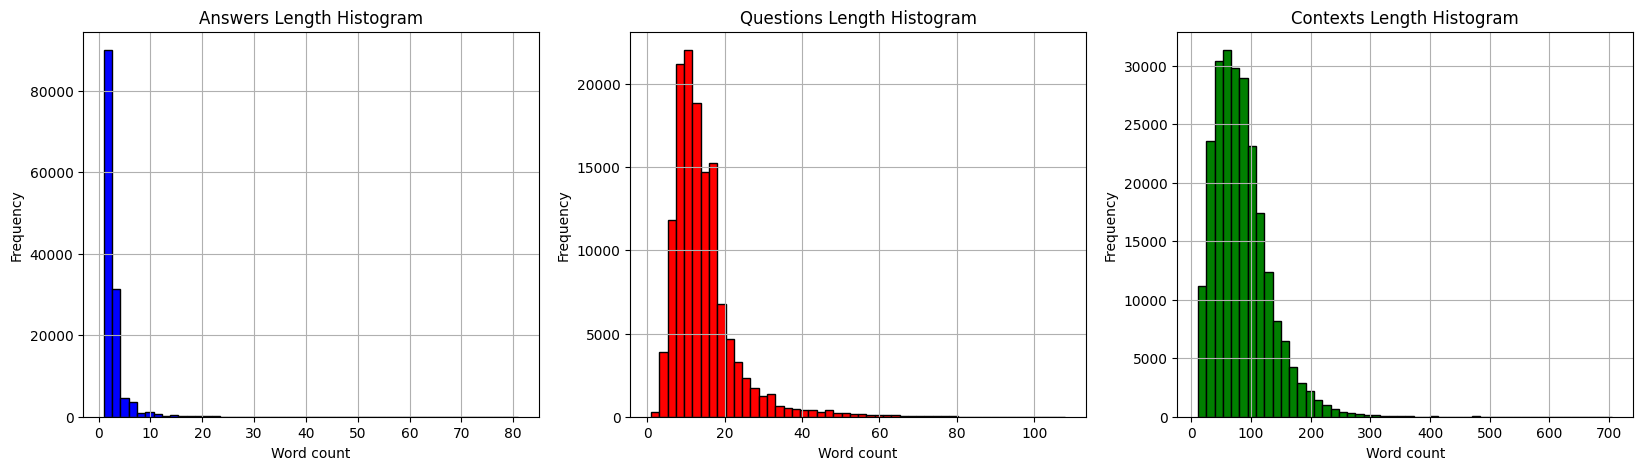

In [ ]:
length_stats(df['question'], df['answers'], df['context'])

##### Processed text

Longest question length: 67
Longest answer length: 53
Longest context length: 391


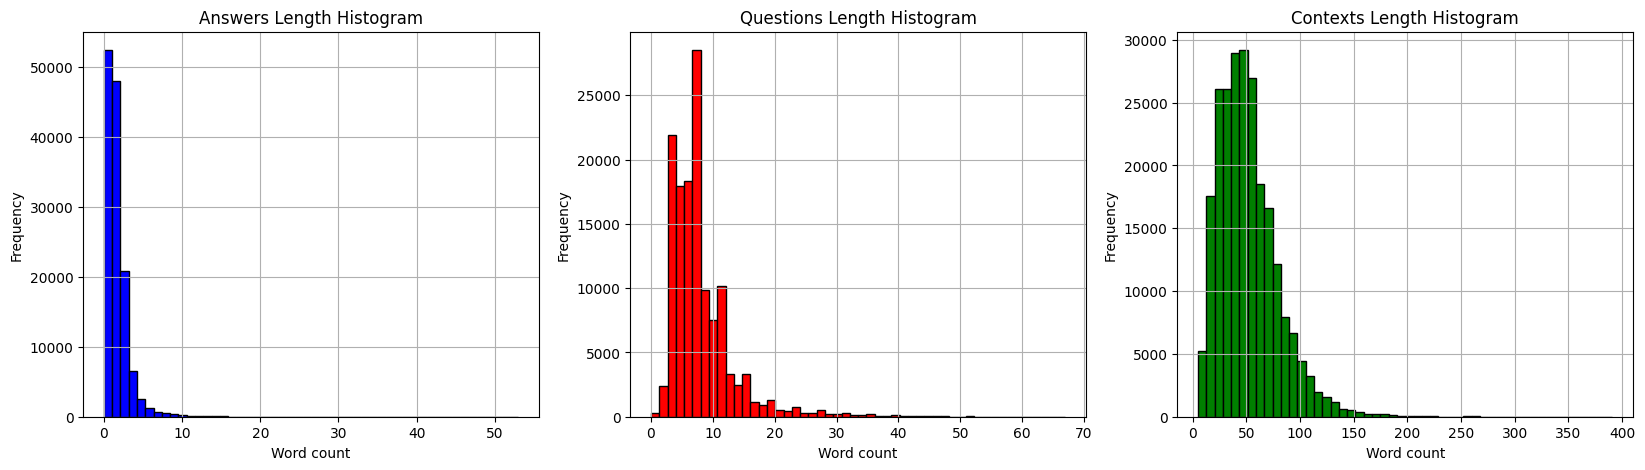

In [ ]:
length_stats(processed_df['question'], processed_df['answer'], processed_df['context'])

### Vocabulary

Let's now create and inspect the vocabulary.

In [ ]:
words = []

words.append([w for ws in processed_df['question'] for w in ws])
words.append([w for ws in processed_df['answer'] for w in ws])
words.append([w for c in processed_df['context'] for ws in c for w in ws[1]])

words = np.concatenate((words[0], words[1], words[2]), axis = 0)
words.shape

(13618291,)

The total length of the whole training dataset, after preprocessing, is of 13'618'291 words.

In [ ]:
vocabulary, occurrencies = np.unique(words, return_counts=True)
len(vocabulary)

233967

The length of the dataset vocabulary consists in 233'967 unique words.

Let's now see what are the 10 most used terms.

In [ ]:
top_terms = np.argsort(occurrencies)[::-1]
for i in range(10):
  print(vocabulary[top_terms[i]], ': ', occurrencies[top_terms[i]])

film :  86604
american :  71170
also :  58280
state :  58182
first :  56934
born :  47596
one :  46981
new :  46324
known :  45976
city :  42535


### Clustering

Let's try to perform clustering. In order to do so we created a new variable that merges question answer and relative context, so that we can see a datapoint as a document.

Since our dataset is obtained by merging different datasets, we remove the source column to avoid having clustering based on this element. Following the same principle we also drop the id column.

In [ ]:
processed_df.head()

,question,answer,context
0,"[wordsworth, initially, attack, burke]",[1793],"[[[edmund, burke], [19th, century, burke, praised, liberal, conservative, burke, friend, philip, francis, wrote, burke, man, truly, prophetically, foresaw, consequence, would, rise, adoption, french, principle, burke, wrote, much, passion, people, doubtful, argument, william, windham, spoke, bench, house, common, burke, separated, fox, observer, said, windham, spoke, like, ghost, burke, made, speech, peace, france, 1801, william, hazlitt, political, opponent, burke, regarded, amongst, three, favourite, writer, others, junius, rousseau, made, test, sense, candour, one, belonging, opposite, party, whether, allowed, burke, great, man, william, wordsworth, originally, supporter, french, revo..."
1,"[clash, henry, iv, pope, part, greater, conflict]","[investiture, controversy]","[[[middle, age], [early, high, middle, age, germany, ruled, ottonian, dynasty, struggled, control, powerful, duke, ruling, territorial, duchy, tracing, back, migration, period, 1024, replaced, salian, dynasty, famously, clashed, papacy, emperor, henry, iv, r, 10841105, church, appointment, part, investiture, controversy, successor, continued, struggle, papacy, well, german, nobility, period, instability, followed, death, emperor, henry, v, r, 111125, died, without, heir, frederick, barbarossa, r, 115590, took, imperial, throne, although, ruled, effectively, basic, problem, remained, successor, continued, struggle, 13th, century, barbarossa, grandson, frederick, ii, r, 12201250, also, hei..."
2,"[historical, event, brought, fall, robespierre]","[thermidorian, reaction]","[[[napoleon], [contemporary, alleged, bonaparte, put, house, arrest, nice, association, robespierre, following, fall, thermidorian, reaction, july, 1794, napoleon, secretary, bourrienne, disputed, allegation, memoir, according, bourrienne, jealousy, responsible, army, alp, army, italy, napoleon, seconded, time, bonaparte, dispatched, impassioned, defence, letter, commissar, saliceti, subsequently, acquitted, wrongdoing, released, within, two, week, due, technical, skill, asked, draw, plan, attack, italian, position, context, france, war, austria, also, took, part, expedition, take, back, corsica, british, french, repulsed, british, royal, navy]]]"
3,"[came, policy, indigenous, autonomy]",[morale],"[[[indigenous, people, america], [morale, began, work, indigenous, autonomy, policy, launched, eastern, lowland, department, 3, august, 2009, bolivia, first, nation, history, south, america, affirm, right, indigenous, people, selfgovernment, speaking, santa, cruz, department, president, called, historic, day, peasant, indigenous, movement, saying, though, might, make, error, would, never, betray, fight, started, ancestor, fight, bolivian, people, vote, autonomy, jurisdiction, took, place, december, 2009, time, general, election, office, issue, divided, country]]]"
4,"[greg, hoffman, working, saw, iii, 2006, american, horror, film, unable, finish, work, film, directed]","[darren, lynn, bousman]","[[[saw, iii], [saw, iii, 2006, horror, film, directed, darren, lynn, bousman, screenplay, leigh, whannell, story, whannell, james, wan, third, installment, saw, film, series, film, star, tobin, bell, shawnee, smith, angus, macfadyen, bahar, soomekh, dina, meyer]], [[saw, iii], [story, follows, jeff, man, son, killed, drunk, driver, put, series, test, jigsaw, order, try, get, let, go, vengeance, man, killed, son, meanwhile, bedridden, john, kramer, apprentice, amanda, young, kidnap, dr, lynn, denlon, tasked, keeping, john, alive, one, final, test, dy]], [[gregg, hoffman], [gregg, hoffman, june, 11, 1963, december, 4, 2005, born, phoenix, arizona, film, producer, responsible, developing, s..."


In [ ]:
qa = []

for iter in range(len(processed_df)):
  qa_string = ''
  for w in processed_df.iloc[iter]['question']:
    qa_string = qa_string + ' ' + w
  for w in processed_df.iloc[iter]['answer']:
    qa_string = qa_string + ' ' + w
  qa.append(qa_string)


print(len(qa))
qa = set(qa)
print(len(qa))

134043
133890


In [ ]:
qa = list(qa)

In [ ]:
tfifd_vectorizer_c = TfidfVectorizer(max_df=0.7, min_df=0.0005, stop_words='english')
tfidf_vectorizer_qa = TfidfVectorizer(max_df=0.7, min_df=0.0003, stop_words='english')

tfifd_vectorizer_c.fit(documents)
tfidf_vectorizer_qa.fit(qa)

TfidfVectorizer(max_df=0.7, min_df=0.0003, stop_words='english')

In [ ]:
tfidf_vector_c = tfifd_vectorizer_c.transform(documents)
tfidf_vector_qa = tfidf_vectorizer_qa.transform(qa)
tfidf_vector_c.shape, tfidf_vector_qa.shape

((119313, 8276), (133890, 4184))

In [ ]:
print(tfidf_vector_c[2], '\n\n', tfidf_vector_qa[2])

  (0, 7358)	0.136234724970719
  (0, 6678)	0.333295031592733
  (0, 6669)	0.13483244622639276
  (0, 6578)	0.1646481771242386
  (0, 6572)	0.13980440117532308
  (0, 6342)	0.188897278548785
  (0, 5952)	0.1763189863675481
  (0, 5338)	0.10288648787163641
  (0, 4789)	0.16594571466765
  (0, 4447)	0.1300044722961789
  (0, 3331)	0.16093520683757437
  (0, 2806)	0.20357071873270172
  (0, 2470)	0.1789295947078798
  (0, 2320)	0.10316966730407114
  (0, 1882)	0.12856696900591555
  (0, 1689)	0.266356083211872
  (0, 1546)	0.3045429861473298
  (0, 1490)	0.35328234018798677
  (0, 1260)	0.14733712256789747
  (0, 1153)	0.1773813501086414
  (0, 1068)	0.2152085060782044
  (0, 827)	0.1988913506739686
  (0, 710)	0.19085848164743752
  (0, 298)	0.22897035315237338
  (0, 264)	0.1169872870454618
  (0, 186)	0.1646481771242386 

   (0, 4102)	0.24358241366432853
  (0, 3953)	0.187855204574347
  (0, 3912)	0.2799200555063792
  (0, 3339)	0.22831582221237529
  (0, 3220)	0.25554993076227844
  (0, 2966)	0.6924636990260885
  (

Let's now check the vocabulary extracted from TFIDF, that takes into account the relevance of words.

In [ ]:
tfidf_vocab_c = tfifd_vectorizer_c.get_feature_names_out()
tfidf_vocab_qa = tfidf_vectorizer_qa.get_feature_names_out()
tfidf_vocab_c.shape, tfidf_vocab_qa.shape

((8276,), (4184,))

In [ ]:
for i in range(5):
    idx1 = np.random.choice(len(documents))
    print(documents[idx1], '\n', list(tfifd_vectorizer_c.inverse_transform(tfidf_vector_c[idx1])))
    print(np.argmax(tfidf_vector_c[idx1]), '--> ', tfidf_vocab_c[np.argmax(tfidf_vector_c[idx1])])
    print('\n\n')
for i in range (10):
    idx2 = np.random.choice(len(qa))
    print(qa[idx2], '\n', list(tfidf_vectorizer_qa.inverse_transform(tfidf_vector_qa[idx2])))
    print(np.argmax(tfidf_vector_qa[idx2]), '--> ', tfidf_vocab_qa[np.argmax(tfidf_vector_qa[idx2])])
    print('\n\n')

 quarrel oberon titania oil canvas painting scottish artist sir joseph noel paton painted 1849 depicts scene william shakespeare comedy play midsummer night dream fairy queen titania fairy king oberon quarrel oberon considered king fairy medieval renaissance literature exhibited edinburgh 1850 declared painting season acquired national gallery scotland 1897 initially bought royal association promoting fine art scotland 1850 earlier version painting paton diploma picture submitted royal scottish academy 1846 paid 700 
 [array(['william', 'version', 'submitted', 'sir', 'shakespeare', 'season',
       'scottish', 'scotland', 'scene', 'royal', 'renaissance', 'queen',
       'promoting', 'play', 'picture', 'painting', 'painted', 'paid',
       'oil', 'noel', 'night', 'national', 'midsummer', 'medieval',
       'literature', 'king', 'joseph', 'initially', 'gallery', 'fine',
       'fairy', 'exhibited', 'edinburgh', 'earlier', 'dream', 'diploma',
       'depicts', 'declared', 'considered', 'c

To find the right numebr of cluster we use the knee-elbow method that help us find the sweet spot between cohesion and separateness.


In [ ]:
def find_k(x, min_k = 2, max_k = 200, step = 1):

    wss = []
    tss = np.sum(np.linalg.norm(x - np.mean(x, axis=0)) ** 2)

    for k in tqdm(range(min_k, max_k, step)):

        kmeans = MiniBatchKMeans(n_clusters=k, batch_size=1000, random_state=45, n_init='auto').fit(x)
        wss.append(kmeans.inertia_)
        cluster_ids, cluster_sizes = np.unique(kmeans.labels_, return_counts=True)

    kn = KneeLocator(x=list(range(min_k, max_k, step)),
                 y=list(wss),
                 curve='convex',
                 direction='decreasing')
    k = kn.knee

    fig = plt.figure(figsize=(20,8))
    font = {'family' : 'sans', 'size'   : 6}
    plt.rc('font', **font)
    plt.plot(range(min_k, max_k, step), wss, 'o-', color='red', label='WCSS')
    plt.plot(range(min_k, max_k, step), tss - wss, 'o-', color='blue', label='BCSS')
    plt.xlabel('Number of clusters')
    plt.title('KMeans Clustering');
    plt.legend(['WCSS', 'BCSS'])
    plt.grid(True)
    plt.show()
    print(f"The knee is at {k} clusters")
    return k

100%|██████████| 118/118 [00:31<00:00,  3.79it/s]


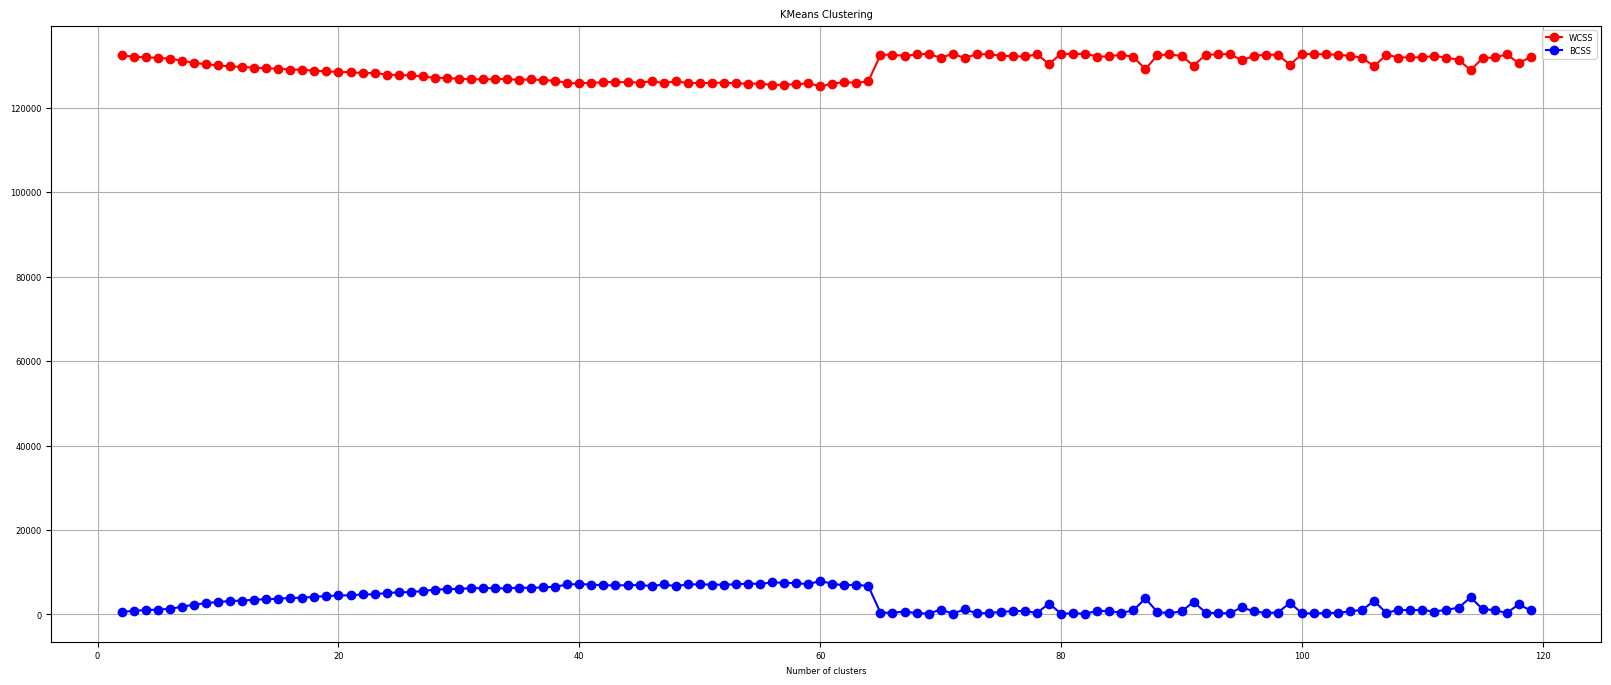

The knee is at 16 clusters


16

In [ ]:
# Knee-elbow analysis for the questions-answers
find_k(tfidf_vector_qa, min_k = 2, max_k = 120, step = 1)

In [ ]:
def SilhouetteAnalysis(x, min_k=2, max_k=100, step=1):
    silhouette_scores = []

    for k in tqdm(range(min_k, max_k + 1, step)):

        kmeans = MiniBatchKMeans(n_clusters=k, batch_size=500, random_state=42, n_init='auto')

        kmeans.fit(x)
        cluster_labels = kmeans.labels_
        silhouette_avg = silhouette_score(x, cluster_labels)
        silhouette_scores.append(silhouette_avg)
        print('Cluster: ', k)
        print('Silhouette: ', silhouette_scores[-1], '\n')


    plt.figure(figsize=(10, 6))
    plt.plot(range(min_k, max_k + 1, step), silhouette_scores, marker='o', linestyle='-')
    plt.xlabel('Number of clusters')
    plt.ylabel('Silhouette Score')
    plt.title('Silhouette Analysis for Optimal k')
    plt.grid(True)
    plt.show()
    return silhouette_scores

  1%|          | 1/119 [01:47<3:31:14, 107.41s/it]

Cluster:  2
Silhouette:  0.0027375415653107566 



  2%|▏         | 2/119 [03:34<3:29:18, 107.34s/it]

Cluster:  3
Silhouette:  0.003213974081839378 



  3%|▎         | 3/119 [05:22<3:28:15, 107.72s/it]

Cluster:  4
Silhouette:  9.821680073884772e-05 



  3%|▎         | 4/119 [07:09<3:25:51, 107.41s/it]

Cluster:  5
Silhouette:  0.00298952474251315 



  4%|▍         | 5/119 [08:57<3:24:00, 107.37s/it]

Cluster:  6
Silhouette:  0.0024777670598894923 



  5%|▌         | 6/119 [10:43<3:21:38, 107.07s/it]

Cluster:  7
Silhouette:  0.0011516559451972312 



  6%|▌         | 7/119 [12:28<3:18:46, 106.49s/it]

Cluster:  8
Silhouette:  0.005141014930146317 



  7%|▋         | 8/119 [14:13<3:16:10, 106.04s/it]

Cluster:  9
Silhouette:  0.004620616850816018 



  8%|▊         | 9/119 [15:58<3:13:30, 105.55s/it]

Cluster:  10
Silhouette:  0.004124204650131766 



  8%|▊         | 10/119 [17:42<3:10:49, 105.04s/it]

Cluster:  11
Silhouette:  0.00416668634780197 



  9%|▉         | 11/119 [19:25<3:07:54, 104.40s/it]

Cluster:  12
Silhouette:  0.0012097861050706052 



 10%|█         | 12/119 [21:07<3:05:10, 103.84s/it]

Cluster:  13
Silhouette:  0.004656395577443331 



 11%|█         | 13/119 [22:48<3:01:53, 102.96s/it]

Cluster:  14
Silhouette:  0.005320296433152285 



 12%|█▏        | 14/119 [24:29<2:59:00, 102.29s/it]

Cluster:  15
Silhouette:  0.005030444743874635 



 13%|█▎        | 15/119 [26:09<2:56:22, 101.75s/it]

Cluster:  16
Silhouette:  0.0054915151418340165 



 13%|█▎        | 16/119 [27:48<2:52:54, 100.72s/it]

Cluster:  17
Silhouette:  0.008318782185474074 



 14%|█▍        | 17/119 [29:24<2:49:07, 99.49s/it] 

Cluster:  18
Silhouette:  0.0065581614608570095 



 15%|█▌        | 18/119 [31:02<2:46:29, 98.90s/it]

Cluster:  19
Silhouette:  0.0007812237526344059 



 16%|█▌        | 19/119 [32:37<2:42:57, 97.77s/it]

Cluster:  20
Silhouette:  0.002725096922721977 



 17%|█▋        | 20/119 [33:56<2:32:02, 92.14s/it]

Cluster:  21
Silhouette:  0.008433396518394497 



 18%|█▊        | 21/119 [35:32<2:32:27, 93.34s/it]

Cluster:  22
Silhouette:  0.0022139598823676487 



 18%|█▊        | 22/119 [37:07<2:31:30, 93.72s/it]

Cluster:  23
Silhouette:  0.003658575256965105 



 19%|█▉        | 23/119 [46:23<6:12:02, 232.53s/it]

Cluster:  24
Silhouette:  0.010240292760946451 



 20%|██        | 24/119 [1:29:41<24:51:46, 942.17s/it]

Cluster:  25
Silhouette:  0.009768916037913817 



 21%|██        | 25/119 [1:51:03<27:16:05, 1044.31s/it]

Cluster:  26
Silhouette:  0.004145496888134804 



 22%|██▏       | 26/119 [2:22:14<33:23:05, 1292.32s/it]

Cluster:  27
Silhouette:  0.0015352221865823719 



 23%|██▎       | 27/119 [2:43:06<32:42:42, 1280.03s/it]

Cluster:  28
Silhouette:  0.0005504534229312524 



 24%|██▎       | 28/119 [3:20:36<39:43:04, 1571.25s/it]

Cluster:  29
Silhouette:  0.004913234941198963 



 24%|██▍       | 29/119 [3:43:02<37:35:20, 1503.56s/it]

Cluster:  30
Silhouette:  0.0039869907711172275 



 25%|██▌       | 30/119 [4:02:26<34:39:13, 1401.73s/it]

Cluster:  31
Silhouette:  -0.002300415534377892 



 26%|██▌       | 31/119 [4:10:08<27:22:09, 1119.66s/it]

Cluster:  32
Silhouette:  0.003598610203233577 



 27%|██▋       | 32/119 [4:34:32<29:33:34, 1223.16s/it]

Cluster:  33
Silhouette:  0.0002776331043468738 



 28%|██▊       | 33/119 [5:01:23<31:59:57, 1339.51s/it]

Cluster:  34
Silhouette:  0.001669471741670917 



 29%|██▊       | 34/119 [5:38:30<37:54:43, 1605.69s/it]

Cluster:  35
Silhouette:  -0.0036043937480269564 



 29%|██▉       | 35/119 [6:00:58<35:39:47, 1528.43s/it]

Cluster:  36
Silhouette:  -0.004101195980555604 



 30%|███       | 36/119 [6:02:57<25:29:32, 1105.70s/it]

Cluster:  37
Silhouette:  -0.0025970613769497023 



 31%|███       | 37/119 [6:04:08<18:06:40, 795.13s/it] 

Cluster:  38
Silhouette:  -0.0013695551932009368 



 32%|███▏      | 38/119 [6:05:37<13:07:18, 583.19s/it]

Cluster:  39
Silhouette:  -0.004302774754304526 



 33%|███▎      | 39/119 [6:07:08<9:40:50, 435.63s/it] 

Cluster:  40
Silhouette:  -0.004441474342261991 



 34%|███▎      | 40/119 [6:08:18<7:09:13, 325.99s/it]

Cluster:  41
Silhouette:  -0.003577979723066439 



 34%|███▍      | 41/119 [6:09:48<5:31:38, 255.11s/it]

Cluster:  42
Silhouette:  -0.005480041458381322 



 35%|███▌      | 42/119 [6:11:00<4:16:47, 200.09s/it]

Cluster:  43
Silhouette:  -0.003390665542417855 



 36%|███▌      | 43/119 [6:12:11<3:24:39, 161.57s/it]

Cluster:  44
Silhouette:  -0.008595740396618048 



 37%|███▋      | 44/119 [6:13:40<2:54:41, 139.76s/it]

Cluster:  45
Silhouette:  -0.011291413125955097 



 38%|███▊      | 45/119 [6:14:51<2:26:42, 118.95s/it]

Cluster:  46
Silhouette:  -0.010338804883767368 



 39%|███▊      | 46/119 [6:16:05<2:08:32, 105.65s/it]

Cluster:  47
Silhouette:  -0.010197003870852149 



 39%|███▉      | 47/119 [6:17:20<1:55:39, 96.38s/it] 

Cluster:  48
Silhouette:  -0.010992256029593594 



 40%|████      | 48/119 [6:18:27<1:43:49, 87.74s/it]

Cluster:  49
Silhouette:  -0.008708055711234567 



 41%|████      | 49/119 [6:19:42<1:37:43, 83.76s/it]

Cluster:  50
Silhouette:  -0.006579094198855855 



 42%|████▏     | 50/119 [6:20:51<1:31:19, 79.41s/it]

Cluster:  51
Silhouette:  -0.0144179116048741 



 43%|████▎     | 51/119 [6:22:00<1:26:24, 76.24s/it]

Cluster:  52
Silhouette:  -0.018198969776500065 



 44%|████▎     | 52/119 [6:23:34<1:30:56, 81.45s/it]

Cluster:  53
Silhouette:  -0.018978321266363233 



 45%|████▍     | 53/119 [6:24:42<1:25:12, 77.47s/it]

Cluster:  54
Silhouette:  -0.011253353442085076 



 45%|████▌     | 54/119 [6:25:52<1:21:27, 75.19s/it]

Cluster:  55
Silhouette:  -0.014814896336587037 



 46%|████▌     | 55/119 [6:27:24<1:25:41, 80.33s/it]

Cluster:  56
Silhouette:  -0.01955440197582862 



 47%|████▋     | 56/119 [6:28:43<1:24:02, 80.03s/it]

Cluster:  57
Silhouette:  -0.01319959648268711 



 48%|████▊     | 57/119 [6:29:52<1:19:08, 76.60s/it]

Cluster:  58
Silhouette:  -0.016434370027515972 



 49%|████▊     | 58/119 [6:31:05<1:16:55, 75.67s/it]

Cluster:  59
Silhouette:  -0.018159080219853813 



 50%|████▉     | 59/119 [6:32:16<1:14:02, 74.04s/it]

Cluster:  60
Silhouette:  -0.013019425944200174 



 50%|█████     | 60/119 [6:33:28<1:12:13, 73.45s/it]

Cluster:  61
Silhouette:  -0.012917051709256094 



 51%|█████▏    | 61/119 [6:35:02<1:16:59, 79.64s/it]

Cluster:  62
Silhouette:  -0.023749296688819067 



 52%|█████▏    | 62/119 [6:36:12<1:12:53, 76.74s/it]

Cluster:  63
Silhouette:  -0.021107985400152057 



 53%|█████▎    | 63/119 [6:37:19<1:08:55, 73.86s/it]

Cluster:  64
Silhouette:  -0.013571092554402744 



 54%|█████▍    | 64/119 [6:38:29<1:06:46, 72.84s/it]

Cluster:  65
Silhouette:  -0.022352640377668313 



 55%|█████▍    | 65/119 [6:39:39<1:04:39, 71.84s/it]

Cluster:  66
Silhouette:  -0.028829816828374207 



 55%|█████▌    | 66/119 [6:40:50<1:03:11, 71.53s/it]

Cluster:  67
Silhouette:  -0.020134725615250273 



 56%|█████▋    | 67/119 [6:42:01<1:02:00, 71.55s/it]

Cluster:  68
Silhouette:  -0.018375246876420417 



 57%|█████▋    | 68/119 [6:43:13<1:00:55, 71.68s/it]

Cluster:  69
Silhouette:  -0.019507477146997364 



 58%|█████▊    | 69/119 [6:44:25<59:41, 71.63s/it]  

Cluster:  70
Silhouette:  -0.02293183642550274 



 59%|█████▉    | 70/119 [6:45:32<57:21, 70.24s/it]

Cluster:  71
Silhouette:  -0.02558889571385921 



 60%|█████▉    | 71/119 [6:46:37<55:00, 68.77s/it]

Cluster:  72
Silhouette:  -0.06157881859618348 



 61%|██████    | 72/119 [6:48:08<59:01, 75.35s/it]

Cluster:  73
Silhouette:  -0.027102591615845748 



 61%|██████▏   | 73/119 [6:49:13<55:24, 72.27s/it]

Cluster:  74
Silhouette:  -0.02172120549609603 



 62%|██████▏   | 74/119 [6:50:16<52:12, 69.62s/it]

Cluster:  75
Silhouette:  -0.00932843393448 



 63%|██████▎   | 75/119 [6:51:33<52:36, 71.73s/it]

Cluster:  76
Silhouette:  -0.02691349923711207 



 64%|██████▍   | 76/119 [6:52:42<50:51, 70.97s/it]

Cluster:  77
Silhouette:  -0.027195664698026874 



 65%|██████▍   | 77/119 [6:53:47<48:28, 69.25s/it]

Cluster:  78
Silhouette:  -0.028022295622247194 



 66%|██████▌   | 78/119 [6:55:04<48:49, 71.46s/it]

Cluster:  79
Silhouette:  -0.03438909584191142 



 66%|██████▋   | 79/119 [6:56:09<46:23, 69.58s/it]

Cluster:  80
Silhouette:  -0.02955324578369687 



 67%|██████▋   | 80/119 [6:57:18<45:05, 69.37s/it]

Cluster:  81
Silhouette:  -0.03110008506693029 



 68%|██████▊   | 81/119 [6:58:22<42:49, 67.63s/it]

Cluster:  82
Silhouette:  -0.032419836111720716 



 69%|██████▉   | 82/119 [6:59:28<41:22, 67.10s/it]

Cluster:  83
Silhouette:  -0.03247262698404283 



 70%|██████▉   | 83/119 [7:00:34<40:05, 66.81s/it]

Cluster:  84
Silhouette:  -0.0331689158428383 



 71%|███████   | 84/119 [7:01:43<39:22, 67.49s/it]

Cluster:  85
Silhouette:  -0.03758390059160757 



 71%|███████▏  | 85/119 [7:02:47<37:36, 66.38s/it]

Cluster:  86
Silhouette:  -0.06957894489881829 



 72%|███████▏  | 86/119 [7:03:51<36:13, 65.88s/it]

Cluster:  87
Silhouette:  -0.03518166097018033 



 73%|███████▎  | 87/119 [7:04:55<34:46, 65.20s/it]

Cluster:  88
Silhouette:  -0.04513512239693047 



 74%|███████▍  | 88/119 [7:05:59<33:30, 64.85s/it]

Cluster:  89
Silhouette:  -0.08020349730996344 



 75%|███████▍  | 89/119 [7:07:03<32:15, 64.53s/it]

Cluster:  90
Silhouette:  -0.06278146220583647 



 76%|███████▌  | 90/119 [7:08:07<31:06, 64.37s/it]

Cluster:  91
Silhouette:  -0.06925509874821484 



 76%|███████▋  | 91/119 [7:09:13<30:18, 64.96s/it]

Cluster:  92
Silhouette:  -0.050217806749333835 



 77%|███████▋  | 92/119 [7:10:29<30:44, 68.32s/it]

Cluster:  93
Silhouette:  -0.03689424999266453 



 78%|███████▊  | 93/119 [7:11:34<29:08, 67.27s/it]

Cluster:  94
Silhouette:  -0.03552709434087339 



 79%|███████▉  | 94/119 [7:12:40<27:48, 66.76s/it]

Cluster:  95
Silhouette:  -0.04350903892246384 



 80%|███████▉  | 95/119 [7:13:43<26:18, 65.76s/it]

Cluster:  96
Silhouette:  -0.03637614619806047 



 81%|████████  | 96/119 [7:14:46<24:55, 65.03s/it]

Cluster:  97
Silhouette:  -0.057052047813640525 



 82%|████████▏ | 97/119 [7:15:50<23:40, 64.55s/it]

Cluster:  98
Silhouette:  -0.05814123236021923 



 82%|████████▏ | 98/119 [7:16:57<22:55, 65.48s/it]

Cluster:  99
Silhouette:  -0.0383493617311857 



 83%|████████▎ | 99/119 [7:18:01<21:37, 64.87s/it]

Cluster:  100
Silhouette:  -0.012078332164821726 



 84%|████████▍ | 100/119 [7:19:05<20:28, 64.64s/it]

Cluster:  101
Silhouette:  -0.04274789888115077 



 85%|████████▍ | 101/119 [7:20:13<19:42, 65.67s/it]

Cluster:  102
Silhouette:  -0.03905761711126064 



 86%|████████▌ | 102/119 [7:21:17<18:29, 65.27s/it]

Cluster:  103
Silhouette:  -0.045579673917911304 



 87%|████████▋ | 103/119 [7:22:22<17:22, 65.18s/it]

Cluster:  104
Silhouette:  -0.0348599151617257 



 87%|████████▋ | 104/119 [7:23:36<16:55, 67.67s/it]

Cluster:  105
Silhouette:  -0.04714053280830704 



 88%|████████▊ | 105/119 [7:24:44<15:47, 67.68s/it]

Cluster:  106
Silhouette:  -0.05712063743152076 



 89%|████████▉ | 106/119 [7:25:48<14:26, 66.63s/it]

Cluster:  107
Silhouette:  -0.04109431345801268 



 90%|████████▉ | 107/119 [7:26:53<13:14, 66.23s/it]

Cluster:  108
Silhouette:  -0.03801796507583682 



 91%|█████████ | 108/119 [7:27:57<12:01, 65.61s/it]

Cluster:  109
Silhouette:  -0.011577301049005576 



 92%|█████████▏| 109/119 [7:29:01<10:51, 65.12s/it]

Cluster:  110
Silhouette:  -0.025670621019526295 



 92%|█████████▏| 110/119 [7:30:06<09:44, 64.94s/it]

Cluster:  111
Silhouette:  -0.0413495454288085 



 93%|█████████▎| 111/119 [7:31:09<08:35, 64.49s/it]

Cluster:  112
Silhouette:  -0.03686997714517171 



 94%|█████████▍| 112/119 [7:32:13<07:29, 64.20s/it]

Cluster:  113
Silhouette:  -0.052911771393532495 



 95%|█████████▍| 113/119 [7:33:20<06:30, 65.14s/it]

Cluster:  114
Silhouette:  -0.04464681660419803 



 96%|█████████▌| 114/119 [7:34:24<05:24, 64.95s/it]

Cluster:  115
Silhouette:  -0.03737739037410865 



 97%|█████████▋| 115/119 [7:35:28<04:18, 64.62s/it]

Cluster:  116
Silhouette:  -0.02875332640085505 



 97%|█████████▋| 116/119 [7:36:32<03:13, 64.39s/it]

Cluster:  117
Silhouette:  -0.033821807905177026 



 98%|█████████▊| 117/119 [7:37:36<02:08, 64.26s/it]

Cluster:  118
Silhouette:  -0.03456584455511844 



 99%|█████████▉| 118/119 [7:38:40<01:04, 64.20s/it]

Cluster:  119
Silhouette:  -0.019087986805146655 



100%|██████████| 119/119 [7:39:44<00:00, 231.80s/it]

Cluster:  120
Silhouette:  -0.08448890279444192 



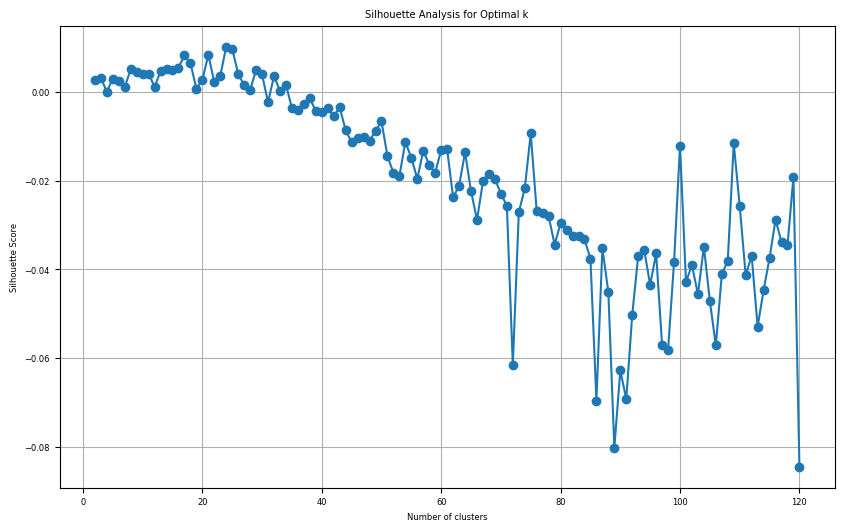

In [ ]:
qa_ss = SilhouetteAnalysis(tfidf_vector_qa, max_k=120)

In [ ]:
with open(os.path.join(path,"silhouettescores_qa"), "wb") as fp:
  pickle.dump(qa_ss, fp)

In [ ]:
print(f"The number cluster with the highest average silhouette is {np.argmax(qa_ss)+2}, with silhouette: {qa_ss[np.argmax(qa_ss)]}.")

The number cluster with the highest average silhouette is 24, with silhouette: 0.010240292760946451.


In [ ]:
for i in range(len(qa_ss)):
    if np.argsort(qa_ss)[i] < 180:
        print(np.argsort(qa_ss)[i], qa_ss[np.argsort(qa_ss)[i]])

0 0.14199107568845742
1 0.15228907873695077
2 0.1760838772560477
3 0.1929365200384713
4 0.20084731142776985
5 0.20891933172558513
6 0.2134375654494824
7 0.2187838719122162
8 0.22459440399680564
9 0.23744575382689864
11 0.25223727936423485
10 0.25288400910268555
12 0.2540138978924114
13 0.25620442015668676
14 0.2574852461731774
15 0.26444099556449574
16 0.2747585154320439
17 0.28447048666989777
18 0.30307362427800666
19 0.3138972416936346
20 0.3143899586160759
21 0.31666948179722654
22 0.3179777321167151
24 0.3199149950529205
23 0.3210688950528868
26 0.32759266285741695
25 0.32866008678901637
27 0.3454269171457135
28 0.34654578900555805
30 0.35303916843337035
29 0.3565178096920946
31 0.361403624991812
32 0.36831830696282747
33 0.3689266498394968
34 0.3768271556671368
36 0.38465880655647805
37 0.3906055138475456
35 0.3914672687680664
38 0.39370064495067847
39 0.4012192038489502
40 0.4014446017906683
42 0.4015872965329421
41 0.4030307422639508
43 0.40539963896090125
46 0.4117938264853109


Let's now perform clustering using Kmeans with 27 clusters.

In [ ]:
k_qa = 24 #110, 54, 21

In [ ]:
kmeans_qa = KMeans(n_clusters=k_qa, random_state=42, n_init='auto').fit(tfidf_vector_qa)
silhouette_score(tfidf_vector_qa, kmeans_qa.labels_)

0.014312663912788477

In [ ]:
qa_per_cluster = []

for i in range(k_qa):
  mask = []
  for j in range(len(kmeans_qa.labels_)):
    if kmeans_qa.labels_[j] == i:
      mask.append(j)
  tmp = [qa[i] for i in np.random.choice(mask,5)]
  qa_per_cluster.append(tmp)

len(doc_per_cluster), len(doc_per_cluster[0]), len(qa_per_cluster), len(qa_per_cluster[0])

(30, 5, 24, 5)

Let's see how the clusters are made

In [ ]:
print(f"--------- QA Clusters ---------")
for i in np.random.choice(range(k_qa), 10, replace = False):
  print(f"--------- Cluster {i} ---------")
  for q in qa_per_cluster[i]:
    print(tfidf_vectorizer_qa.inverse_transform(tfidf_vector_qa[qa.index(q)])[0])
    print(q)
    print()
  print('\n\n')

--------- QA Clusters ---------
--------- Cluster 8 ---------
['state' 'result' 'religion' 'relationship' 'policy' 'occurs' 'government'
 'close']
 excessive entanglement occurs state policy result close relationship government religion



['west' 'united' 'state' 'located' 'key' 'island' 'international'
 'country' 'block' 'airport']
 key west international airport block island state airport located country united state



['voted' 'state' 'parliament' 'member' 'declaration']
 many parliament member voted declaration state sovereignty ukraine four



['technique' 'state' 'sort' 'employed' 'department' 'china']
 sort technique state department conclude still employed china coercive technique



['state' 'public' 'minnesota' 'job' 'jesse' 'hold' 'general' 'election'
 'attorney' '1998']
 public job jesse ventura challenger minnesota 1998 election hold attorney general state






--------- Cluster 21 ---------
['ultimate' 'ufc' 'trained' 'tournament' 'team' 'separate' 'randy' 'mixed'
 'ma

### Word2Vec Embedding

#### Building the model

In [ ]:
qa_full = []

for iter in range(len(processed_df)):
  qa_full.append(processed_df.iloc[iter]['question'] + processed_df.iloc[iter]['answer'])


qa_full[:3]

[['wordsworth', 'initially', 'attack', 'burke', '1793'],
 ['clash',
  'henry',
  'iv',
  'pope',
  'part',
  'greater',
  'conflict',
  'investiture',
  'controversy'],
 ['historical',
  'event',
  'brought',
  'fall',
  'robespierre',
  'thermidorian',
  'reaction'],
 ['came', 'policy', 'indigenous', 'autonomy', 'morale'],
 ['greg',
  'hoffman',
  'working',
  'saw',
  'iii',
  '2006',
  'american',
  'horror',
  'film',
  'unable',
  'finish',
  'work',
  'film',
  'directed',
  'darren',
  'lynn',
  'bousman']]

In [ ]:
model = Word2Vec(qa_full, vector_size=50, min_count=5, window=10)
len(model.wv)

22215

In [ ]:
print(model.wv.key_to_index)

{'film': 0, 'american': 1, 'year': 2, 'first': 3, 'city': 4, 'state': 5, 'born': 6, 'name': 7, 'many': 8, 'new': 9, 'known': 10, 'located': 11, 'country': 12, 'university': 13, 'band': 14, 'actor': 15, 'one': 16, 'album': 17, 'song': 18, 'company': 19, 'team': 20, 'directed': 21, 'united': 22, 'released': 23, 'played': 24, 'type': 25, 'series': 26, 'also': 27, 'football': 28, 'based': 29, 'game': 30, 'world': 31, 'john': 32, 'group': 33, 'play': 34, 'actress': 35, 'county': 36, 'war': 37, 'yes': 38, 'two': 39, 'director': 40, 'music': 41, 'english': 42, 'singer': 43, 'part': 44, 'star': 45, 'south': 46, 'television': 47, 'national': 48, 'british': 49, 'used': 50, 'season': 51, 'time': 52, 'member': 53, 'starred': 54, 'u': 55, 'school': 56, 'player': 57, 'founded': 58, 'best': 59, 'award': 60, 'people': 61, 'movie': 62, 'book': 63, 'role': 64, 'written': 65, 'work': 66, 'show': 67, 'former': 68, 'common': 69, 'rock': 70, 'york': 71, 'park': 72, 'character': 73, 'made': 74, 'league': 75,

#### Inspecting the embedding

In [ ]:
term = 'film'
model.wv[term]

array([-4.3438334 ,  0.3168422 ,  3.7554624 ,  3.0437665 ,  0.6658208 ,
        2.3326538 ,  1.2035073 ,  3.2072432 , -0.48575023,  1.4751467 ,
       -0.6690527 , -2.3698573 , -3.138295  ,  4.9296966 ,  0.78442127,
        0.8036561 , -2.3803828 ,  1.8692251 , -1.4467908 , -2.6156068 ,
        0.55305207, -0.12322402,  3.8436003 , -1.277514  ,  3.3798954 ,
        1.3747554 , -2.4103284 , -0.12153571, -1.1916472 , -2.715861  ,
       -2.671994  , -0.33592567,  2.7500196 ,  1.3259103 , -0.90084845,
        0.85391575,  1.0325295 ,  0.20662916,  4.5390162 ,  1.4449618 ,
       -2.6184943 ,  0.7426178 , -0.8846159 , -2.4458284 , -0.5263753 ,
       -4.708688  , -1.2202511 ,  5.0946927 ,  1.681083  ,  3.471881  ],
      dtype=float32)

In [ ]:
most_pop = vocabulary[top_terms[:15]]

for term in most_pop:
  print('----------------- ', term, ' -----------------')
  print(model.wv.most_similar(term))

-----------------  film  -----------------
[('movie', 0.8829125761985779), ('romantic', 0.8239847421646118), ('drama', 0.823789119720459), ('thriller', 0.8205112218856812), ('aur', 0.7822281122207642), ('horror', 0.7821466326713562), ('comedy', 0.7762923836708069), ('comedydrama', 0.7726231813430786), ('thrillerdrama', 0.7683952450752258), ('epic', 0.7676302194595337)]
-----------------  american  -----------------
[('canadian', 0.6390314698219299), ('pornographic', 0.5710492730140686), ('hollywood', 0.5608748197555542), ('personality', 0.5601348876953125), ('producer', 0.5571131110191345), ('british', 0.5544835925102234), ('started', 0.542100191116333), ('podcast', 0.5403650999069214), ('restaurateur', 0.5400131344795227), ('markle', 0.527316689491272)]
-----------------  also  -----------------
[('best', 0.7571353316307068), ('well', 0.7278560400009155), ('formerly', 0.6923966407775879), ('popularly', 0.6494583487510681), ('professionally', 0.6472765207290649), ('better', 0.630216598

In [ ]:
sample = np.random.choice(list(model.wv.key_to_index), 2000)
print(sample)

vectors_word = model.wv[sample]

['ure' 'shyam' '38th' ... 'misadventure' 'bedlington' 'wwe']


In [ ]:
tsne = TSNE(n_components=3, n_iter=5000)

tsne_embedding = tsne.fit_transform(vectors_word)
x, y, z = np.transpose(tsne_embedding)

In [ ]:
fig = px.scatter_3d(x=x[:500],y=y[:500],z=z[:500],text=sample[:500])
fig.update_traces(marker=dict(size=3,line=dict(width=2)),textfont_size=10)
fig.show()

In [ ]:
model.wv.most_similar('queen')

[('victoria', 0.811680257320404),
 ('coronation', 0.785261332988739),
 ('elizabeth', 0.775392472743988),
 ('consort', 0.7731694579124451),
 ('prince', 0.7703585028648376),
 ('mother', 0.7664786577224731),
 ('embark', 0.6956384181976318),
 ('king', 0.6927974820137024),
 ('princess', 0.6837120056152344),
 ('margrethe', 0.673892080783844)]

Let's test and see if just using the text of the questions and of the answers, the Word2Vec captured some trivial relationship between words.

In [ ]:
vec = model.wv['duke'] + (model.wv['woman'] - model.wv['man'])
vec, model.wv.most_similar([vec], topn=10)

(array([-1.8016287e+00, -1.6439798e+00, -1.0258418e-01, -8.5292184e-01,
        -1.3173227e+00, -2.2684457e+00, -8.6178029e-01,  1.6034710e+00,
        -1.1754231e+00, -1.4943804e+00,  2.6413214e+00, -3.0381748e-01,
         2.2271194e-01, -1.2415034e+00, -4.3409717e-01,  5.9107614e-01,
         1.1607628e+00, -2.6140480e+00, -1.1265603e+00, -6.7191845e-01,
         5.8618814e-02,  9.6835768e-01,  5.5988157e-01,  1.0577648e+00,
        -1.0056964e+00,  8.0122626e-01,  5.2929986e-01, -6.2786371e-02,
        -1.2183501e+00,  2.2325218e+00, -2.5639272e-01,  6.1299551e-01,
        -2.2548289e+00,  9.7978115e-04, -1.5766841e+00, -1.5425030e+00,
         1.3263897e+00,  1.4204764e-01, -5.7185185e-01, -9.3319714e-01,
         1.9997289e+00, -1.7417827e+00,  2.4188012e-02, -5.4538059e-01,
         1.7360234e-01, -3.2516634e-01,  1.1111628e+00, -1.5137389e+00,
        -2.6298788e+00,  1.6094906e+00], dtype=float32),
 [('woman', 0.6821660399436951),
  ('africanamerican', 0.6701169610023499),
  (

In [ ]:
vec = model.wv['paris'] - model.wv['france'] + model.wv['spain']
vec, model.wv.most_similar([vec], topn=10)

(array([ 0.7666273 , -0.04161515, -0.77695584, -0.9959816 , -0.6592263 ,
        -1.0930007 , -0.34799218,  0.8166081 , -1.3286121 , -0.94896346,
         0.28617883, -0.93762875,  0.89864993, -0.01189399, -1.448036  ,
        -0.28789088,  0.5341373 ,  0.00492805, -0.17282045, -0.7283177 ,
        -0.13184512,  0.263412  ,  1.2194729 , -0.3703856 , -0.07058871,
        -0.79606223, -0.7399041 , -0.94767666,  0.16538677,  0.5116239 ,
        -0.19268751,  0.8476475 , -0.4761089 , -0.9320899 , -0.7788299 ,
        -0.9177686 ,  0.82975066,  0.5462929 , -0.4279036 ,  1.8201063 ,
         1.198164  ,  0.547694  , -0.20735395, -0.28029644,  1.1965896 ,
        -0.55715024, -0.95531857,  0.06461751, -0.38302284, -1.2074965 ],
       dtype=float32),
 [('detroit', 0.831257700920105),
  ('venue', 0.8187910914421082),
  ('seattle', 0.8172346949577332),
  ('square', 0.798091471195221),
  ('shopping', 0.7813047170639038),
  ('demolished', 0.7809221744537354),
  ('downtown', 0.7797538042068481),
 

The text that we provided, only using the question and answer text it still isn't able to capture these relationships. Let's see what happens adding the context.

#### Build the model

In [ ]:
documents = []

for iter in range(len(processed_df)):
  for context in processed_df.iloc[iter]['context']:
    documents.append(context[1])

len(documents)

236810

In [ ]:
docs = documents + qa_full

len(docs)

370853

In [ ]:
model_context = Word2Vec(docs, vector_size=50, min_count=5, window=10)
len(model_context.wv)

98015

In [ ]:
print(model_context.wv.key_to_index)

{'film': 0, 'american': 1, 'also': 2, 'state': 3, 'first': 4, 'born': 5, 'one': 6, 'new': 7, 'known': 8, 'city': 9, 'year': 10, 'united': 11, 'album': 12, 'world': 13, 'series': 14, 'two': 15, 'band': 16, 'time': 17, 'university': 18, 'released': 19, 'song': 20, 'music': 21, 'best': 22, 'many': 23, 'name': 24, 'season': 25, 'award': 26, 'game': 27, 'may': 28, 'war': 29, 'national': 30, 'u': 31, 'television': 32, 'group': 33, 'school': 34, 'including': 35, 'part': 36, 'member': 37, 'team': 38, 'country': 39, 'company': 40, 'south': 41, 'role': 42, 'directed': 43, 'football': 44, 'record': 45, 'work': 46, 'john': 47, 'based': 48, 'actor': 49, 'single': 50, 'three': 51, 'area': 52, 'became': 53, 'second': 54, 'british': 55, 'played': 56, 'since': 57, 'used': 58, 'english': 59, 'north': 60, 'later': 61, 'york': 62, 'located': 63, 'rock': 64, 'number': 65, 'century': 66, 'written': 67, 'league': 68, 'well': 69, 'former': 70, 'made': 71, 'people': 72, 'show': 73, 'director': 74, 'family': 75

#### Inspect the context embedding

In [ ]:
term = 'film'
model_context.wv[term]

array([ 7.2147956 ,  3.7537909 ,  1.2270529 , -0.09900063,  0.33230475,
       -0.7022213 , -1.183698  ,  1.9305671 , -1.5126203 , -1.5666462 ,
        1.9523718 , -0.15910928, -5.474493  ,  3.3306198 ,  1.4774778 ,
        5.9208035 ,  1.384842  , -2.2203684 , -2.6602476 , -5.167001  ,
        1.0478637 , -2.5275826 , -0.27880198, -0.39414623,  2.3410609 ,
        0.18351492,  3.7545097 , -3.731798  , -1.2294241 , -1.8132304 ,
       -0.22708285,  0.87121   ,  5.041385  , -2.4739091 ,  3.8359096 ,
       -0.3856485 ,  1.9655399 , -0.9444642 ,  3.433042  ,  0.31073403,
       -6.94718   ,  1.3711369 , -0.38187099, -0.94407177, -8.187547  ,
       -2.8971603 , -3.022954  ,  1.600434  ,  0.1080814 , -1.1988373 ],
      dtype=float32)

In [ ]:
for term in most_pop:
  print('----------------- ', term, ' -----------------')
  print(model_context.wv.most_similar(term))

-----------------  film  -----------------
[('movie', 0.8421836495399475), ('directing', 0.6921364665031433), ('screenplay', 0.675085186958313), ('sequel', 0.6743043065071106), ('blockbuster', 0.6575431823730469), ('spielberg', 0.6473206877708435), ('directorial', 0.6464691758155823), ('screenwriting', 0.6437560319900513), ('lowbudget', 0.6426942944526672), ('seftel', 0.6402267813682556)]
-----------------  american  -----------------
[('mississippi', 0.6122397780418396), ('canadianamerican', 0.5966013073921204), ('africanamerican', 0.5771938562393188), ('canadian', 0.5650286674499512), ('carolina', 0.5572986602783203), ('chicago', 0.5518348217010498), ('americancanadian', 0.548389732837677), ('oklahoma', 0.5436406135559082), ('missouri', 0.5339583158493042), ('tinna', 0.5141928791999817)]
-----------------  also  -----------------
[('previously', 0.7603289484977722), ('well', 0.7540013194084167), ('collectively', 0.6562513709068298), ('widely', 0.6458972096443176), ('popularly', 0.642

In [ ]:
vec = model_context.wv['duke'] + model_context.wv['woman'] - model_context.wv['man']
vec, model_context.wv.most_similar([vec], topn=10)

(array([  4.3023734 ,  -8.807121  ,  -5.782357  ,  -2.6588836 ,
        -11.198413  ,  -4.7742457 ,   2.7441757 ,  -1.0751324 ,
         -1.4732573 ,  -5.124729  ,  -1.5270381 ,   3.888781  ,
         -0.45314503,  -2.2465613 ,   4.8570166 ,  -1.1900849 ,
          3.054953  ,   2.1778338 ,  -3.3685057 ,   2.9756114 ,
          9.097365  ,   0.54080856,  -1.4793977 ,   4.659539  ,
         -2.3976102 ,  -7.575347  ,  -0.19734955,  -1.5776019 ,
         -0.8155449 ,   1.1920662 ,   2.0931787 ,   1.5749192 ,
          0.6050192 ,   2.1682317 ,   4.421194  ,  -5.005629  ,
         -1.6160324 ,   5.9282923 ,  -5.584438  ,  -6.3279495 ,
          1.4003181 ,  -3.895822  ,   4.3938794 ,   4.5925865 ,
          4.3606386 ,   8.586558  ,   4.811644  ,  -2.2244773 ,
         -5.43192   ,  -8.306684  ], dtype=float32),
 [('duke', 0.7990042567253113),
  ('duchess', 0.6775712966918945),
  ('unmarried', 0.6186994910240173),
  ('amity', 0.6016367673873901),
  ('bona', 0.574441134929657),
  ('dukedom

In [ ]:
vec = model_context.wv['paris'] - model_context.wv['france'] + model_context.wv['spain']
vec, model_context.wv.most_similar([vec], topn=10)

(array([-0.8470794 ,  3.8929384 ,  0.08170581,  0.34999186, -6.3472075 ,
        -5.1414986 , -3.7594967 , -7.4491754 ,  2.8820088 , -0.4531839 ,
        -0.61576366, -4.993737  ,  3.2071013 , -4.6898446 ,  0.6713946 ,
         1.2788545 , -3.957831  , -1.8036072 , -1.4135367 ,  0.3820837 ,
         0.15570736, -1.9970548 ,  5.5361223 ,  1.8775092 ,  2.9975672 ,
        -3.485656  , -3.2905846 , -4.1619253 ,  2.66651   ,  4.1545906 ,
         1.2446349 ,  0.13141418, -2.0403526 , -0.70894814, -0.27111912,
         0.50763535,  4.7437534 ,  4.2116885 , -2.389043  , -2.8782105 ,
         2.7318263 , -7.0454435 , -0.05938172, -2.630516  , -3.2986617 ,
         3.4420075 , -1.2736655 , -0.01950693, -1.8131194 , -5.071735  ],
       dtype=float32),
 [('valencia', 0.7539600729942322),
  ('paris', 0.736798107624054),
  ('teatro', 0.7239137887954712),
  ('montevideo', 0.7083408832550049),
  ('porto', 0.7049071788787842),
  ('madrid', 0.704688310623169),
  ('ciudad', 0.6907995939254761),
  ('go

It still does not capture the relationships, but we're definitely getting closer to the wanted result.

### Train-test splitting

In [ ]:
# Split the dataset into train and temp sets
train_data, temp_data = train_test_split(df, train_size=0.8, random_state=42)

# Split the temp set into val and test sets
val_data, test_data = train_test_split(temp_data, train_size=0.5, random_state=42)

# Print the sizes of train, val, and test sets
print("Train set size:", len(train_data))
print("Validation set size:", len(val_data))
print("Test set size:", len(test_data))


Train set size: 107234
Validation set size: 13404
Test set size: 13405


In [ ]:
train_data

,id,src,answers,question,context
24455,9107703d84ea3be648586607b980a7ac5557346e,squad,Early Middle Ages,When was the settlement in Bumpliz close to the medieval city?,"[[Bern, No archaeological evidence that indicates a settlement on the site of today′s city centre prior to the 12th century has been found so far. In antiquity, a Celtic ""oppidum"" stood on the ""Engehalbinsel"" (peninsula) north of Bern, fortified since the second century BC (late La Tène period), thought to be one of the 12 ""oppida"" of the Helvetii mentioned by Caesar. During the Roman era, a Gallo-Roman ""vicus"" was on the same site. The Bern zinc tablet has the name ""Brenodor"" (""dwelling of Breno""). In the Early Middle Ages, a settlement in Bümpliz, now a city district of Bern, was some 4 km from the medieval city.]]"
105662,5a3b5389575ea3f89a2bd497a880d1e8774f6107,hotpotqa,Jonathan Rea,Who was the winner of the 2016 Superbike World Championship?,"[[2016 Superbike World Championship, The 2016 Superbike World Championship was the 29th season of the Superbike World Championship. Jonathan Rea won his second consecutive Superbike World Championship title at the first race of the last round at Losail, while Kawasaki had secured the manufacturers' title at the previous event at Jerez.], [Jonathan Rea, He was world superbike champion in 2015, 2016, 2017, 2018 and 2019, making him the most successful World SBK rider in the championship history. He also holds the highest number of race wins in the superbike championship.], [Jonathan Rea, Previously he was runner-up in the Supersport World Championship for the Ten Kate Honda team in 2008, a..."
10706,a8696b2a567e6c8a9332428bfac5c8ca83fff68f,squad,Texas,In which state is Dell the sixth largest company?,"[[Dell, Dell was listed at number 51 in the ""Fortune 500"" list, until 2014. After going private in 2013, the newly confidential nature of its financial information prevents the company from being ranked by ""Fortune"". In 2015, it was the third largest PC vendor in the world after Lenovo and Hewlett-Packard (HP). Dell is the largest shipper of PC monitors worldwide. Dell is the sixth largest company in Texas by total revenue, according to ""Fortune"" magazine. It is the second largest non-oil company in Texas – behind AT&T – and the largest company in the Greater Austin area. It was a publicly traded company (NASDAQ: DELL ), as well as a component of the NASDAQ-100 and S&P 500, until it was ..."
578,1e8e2263940b780a8720244ddd75d3ba228a37ad,hotpotqa,KHNH,What is the abbreviation for the movie which starred Saif Ali Khan in 2003?,"[[Saif Ali Khan, Saif Ali Khan (] ; born Sajid Ali Khan on 16 August 1970) is an Indian film actor and producer. The son of actress Sharmila Tagore and cricketer Mansoor Ali Khan Pataudi, Khan made his acting debut in Yash Chopra's drama ""Parampara"" (1993), but achieved success with his roles in the romantic drama ""Yeh Dillagi"" and the action film ""Main Khiladi Tu Anari"" (both 1994). Khan's career prospect declined through much of the 1990s, and his biggest commercial success of the decade came with the ensemble drama ""Hum Saath-Saath Hain"" (1999). He rose to prominence with roles in two ensemble comedy-dramas""Dil Chahta Hai"" (2001) and ""Kal Ho Naa Ho"" (2003).], [Saif Ali Khan, The 2004 ..."
101597,ee9c95657d1cd355ea801c56d0285677a2d0b9bb,squad,three,How many subregions are there of Nigeria's savannah zone?,"[[Nigeria, Everything in between the far south and the far north is savannah (insignificant tree cover, with grasses and flowers located between trees). Rainfall is more limited, to between 20 and per year. The savannah zone's three categories are Guinean forest-savanna mosaic, Sudan savannah, and Sahel savannah. Guinean forest-savanna mosaic is plains of tall grass interrupted by trees. Sudan savannah is similar but with shorter grasses and shorter trees. Sahel savannah consists of patches of grass and sand, found in the northeast. In the Sahel region, rain is less tha

# Part 2

In [ ]:
data_path = 'data'
model_path = 'model'

# This will be useful for part 3 of the project
audio_path = os.path.join(data_path, 'audio')

train_path = os.path.join(data_path, 'beerqa_train_v1.0.json')
validation_path = os.path.join(data_path, 'beerqa_dev_v1.0.json')

In [ ]:
RANDOM_SEED = 42
model_name = 'FacebookAI/roberta-base'
batch_size = 16
max_length = 384 # The maximum length of a feature (question and context)
doc_stride = 128 # The authorized overlap between two part of the context when splitting it is needed.

#### Functions definition

In [ ]:
def load_formatted_dataset(file_path, N=None):
    with open(file_path) as file:
        # Load the JSON data into a variable
        data = pd.read_json(file)

    data_dict = data['data']
    if N is not None:
        data_dict = data_dict[:N]

    records = []
    for dd in data_dict:
        context = ''
        for con in dd['context']:
            for cc in con[1::2]:
                context += cc
        record = dd.copy()  # Create a copy of the row of the dictionary
        record['context'] = context
        an_start= context.find(dd['answers'][0])
        record['answers'] = {'answer_start': [an_start], 'text': dd['answers']}
        records.append(record)

    return pd.DataFrame(records)

In [ ]:
def load_formatted_dataset_context(file_path, find_context_function, N=None):
    with open(file_path) as file:
        # Load the JSON data into a variable
        data = pd.read_json(file)

    data_dict = data['data']
    if N is not None:
        data_dict = data_dict[:N]

    records = []
    for i, dd in enumerate(data_dict):
        print(f'{i+1}/{len(data_dict)}')
        record = dd.copy()  # Create a copy of the row of the dictionary
        context = find_context_function(dd['question'])
        record['context'] = context
        an_start= context.find(dd['answers'][0])
        record['answers'] = {'answer_start': [an_start], 'text': dd['answers']}
        records.append(record)

    return pd.DataFrame(records)

In [ ]:
def prepare_train_features(examples):
    pad_on_right = tokenizer.padding_side == "right"

    # Remove left whitespace
    examples["question"] = [q.lstrip() for q in examples["question"]]

    # Tokenize our examples with truncation and padding, but keep the overflows using a stride.
    # This results in one example possible giving several features when a context is long,
    # each of those features having a context that overlaps a bit the context of the previous feature.
    tokenized_examples = tokenizer(
        examples["question" if pad_on_right else "context"],
        examples["context" if pad_on_right else "question"],
        truncation="only_second" if pad_on_right else "only_first",
        max_length=max_length,
        stride=doc_stride,
        return_overflowing_tokens=True,
        return_offsets_mapping=True,
        padding="max_length",
    )

    # Since one example might give us several features if it has a long context,
    # we need a map from a feature to its corresponding example. This key gives us just that.
    sample_mapping = tokenized_examples.pop("overflow_to_sample_mapping")
    # The offset mappings will give us a map from token to character position in the original context.
    # This will help us compute the start_positions and end_positions.
    offset_mapping = tokenized_examples.pop("offset_mapping")

    # Label those examples
    tokenized_examples["start_positions"] = []
    tokenized_examples["end_positions"] = []

    for i, offsets in enumerate(offset_mapping):
        # We will label impossible answers with the index of the CLS token.
        input_ids = tokenized_examples["input_ids"][i]
        cls_index = input_ids.index(tokenizer.cls_token_id)

        # Grab the sequence corresponding to that example (to know what is the context and what is the question).
        sequence_ids = tokenized_examples.sequence_ids(i)

        # One example can give several spans, this is the index of the example containing this span of text.
        sample_index = sample_mapping[i]
        answers = examples["answers"][sample_index]
        # If no answers are given, set the cls_index as answer.
        if len(answers["answer_start"]) == 0:
            tokenized_examples["start_positions"].append(cls_index)
            tokenized_examples["end_positions"].append(cls_index)
        else:
            # Start/end character index of the answer in the text.
            start_char = answers["answer_start"][0]
            end_char = start_char + len(answers["text"][0])

            # Start token index of the current span in the text.
            token_start_index = 0
            while sequence_ids[token_start_index] != (1 if pad_on_right else 0):
                token_start_index += 1

            # End token index of the current span in the text.
            token_end_index = len(input_ids) - 1
            while sequence_ids[token_end_index] != (1 if pad_on_right else 0):
                token_end_index -= 1

            # Detect if the answer is out of the span (in which case this feature is labeled with the CLS index).
            if not (offsets[token_start_index][0] <= start_char and offsets[token_end_index][1] >= end_char):
                tokenized_examples["start_positions"].append(cls_index)
                tokenized_examples["end_positions"].append(cls_index)
            else:
                # Otherwise move the token_start_index and token_end_index to the two ends of the answer.
                # Note: we could go after the last offset if the answer is the last word (edge case).
                while token_start_index < len(offsets) and offsets[token_start_index][0] <= start_char:
                    token_start_index += 1
                tokenized_examples["start_positions"].append(token_start_index - 1)
                while offsets[token_end_index][1] >= end_char:
                    token_end_index -= 1
                tokenized_examples["end_positions"].append(token_end_index + 1)

    return tokenized_examples

In [ ]:
def prepare_validation_features(examples):
    pad_on_right = tokenizer.padding_side == "right"

    # Remove left whitespace
    examples["question"] = [q.lstrip() for q in examples["question"]]

    # Tokenize our examples with truncation and padding, but keep the overflows using a stride.
    # This results in one example possible giving several features when a context is long,
    # each of those features having a context that overlaps a bit the context of the previous feature.
    tokenized_examples = tokenizer(
        examples["question" if pad_on_right else "context"],
        examples["context" if pad_on_right else "question"],
        truncation="only_second" if pad_on_right else "only_first",
        max_length=max_length,
        stride=doc_stride,
        return_overflowing_tokens=True,
        return_offsets_mapping=True,
        padding="max_length",
    )

    # Since one example might give us several features if it has a long context,
    # we need a map from a feature to its corresponding example. This key gives us just that.
    sample_mapping = tokenized_examples.pop("overflow_to_sample_mapping")

    # We keep the example_id that gave us this feature and we will store the offset mappings.
    tokenized_examples["example_id"] = []

    for i in range(len(tokenized_examples["input_ids"])):
        # Grab the sequence corresponding to that example (to know what is the context and what is the question).
        sequence_ids = tokenized_examples.sequence_ids(i)
        context_index = 1 if pad_on_right else 0

        # One example can give several spans, this is the index of the example containing this span of text.
        sample_index = sample_mapping[i]
        tokenized_examples["example_id"].append(examples["id"][sample_index])

        # Set to None the offset_mapping that are not part of the context so it's easy to determine if a token
        # position is part of the context or not.
        tokenized_examples["offset_mapping"][i] = [
            (o if sequence_ids[k] == context_index else None)
            for k, o in enumerate(tokenized_examples["offset_mapping"][i])
        ]

    return tokenized_examples

In [ ]:
def postprocess_qa_predictions(examples, features, raw_predictions, n_best_size = 20, max_answer_length = 30):
    all_start_logits, all_end_logits = raw_predictions
    # Build a map example to its corresponding features.
    example_id_to_index = {k: i for i, k in enumerate(examples["id"])}
    features_per_example = collections.defaultdict(list)
    for i, feature in enumerate(features):
        features_per_example[example_id_to_index[feature["example_id"]]].append(i)

    # The dictionaries we have to fill.
    predictions = collections.OrderedDict()

    # Let's loop over all the examples!
    for example_index, example in enumerate(tqdm(examples)):
        # Those are the indices of the features associated to the current example.
        feature_indices = features_per_example[example_index]

        min_null_score = None # Only used if squad_v2 is True.
        valid_answers = []

        context = example["context"]
        # Looping through all the features associated to the current example.
        for feature_index in feature_indices:
            # We grab the predictions of the model for this feature.
            start_logits = all_start_logits[feature_index]
            end_logits = all_end_logits[feature_index]
            # This is what will allow us to map some the positions in our logits to span of texts in the original
            # context.
            offset_mapping = features[feature_index]["offset_mapping"]

            # Update minimum null prediction.
            cls_index = features[feature_index]["input_ids"].index(tokenizer.cls_token_id)
            feature_null_score = start_logits[cls_index] + end_logits[cls_index]
            if min_null_score is None or min_null_score < feature_null_score:
                min_null_score = feature_null_score

            # Go through all possibilities for the `n_best_size` greater start and end logits.
            start_indexes = np.argsort(start_logits)[-1 : -n_best_size - 1 : -1].tolist()
            end_indexes = np.argsort(end_logits)[-1 : -n_best_size - 1 : -1].tolist()
            for start_index in start_indexes:
                for end_index in end_indexes:
                    # Don't consider out-of-scope answers, either because the indices are out of bounds or correspond
                    # to part of the input_ids that are not in the context.
                    if (
                        start_index >= len(offset_mapping)
                        or end_index >= len(offset_mapping)
                        or offset_mapping[start_index] is None
                        or offset_mapping[end_index] is None
                    ):
                        continue
                    # Don't consider answers with a length that is either < 0 or > max_answer_length.
                    if end_index < start_index or end_index - start_index + 1 > max_answer_length:
                        continue

                    start_char = offset_mapping[start_index][0]
                    end_char = offset_mapping[end_index][1]
                    valid_answers.append(
                        {
                            "score": start_logits[start_index] + end_logits[end_index],
                            "text": context[start_char: end_char]
                        }
                    )

        if len(valid_answers) > 0:
            best_answer = sorted(valid_answers, key=lambda x: x["score"], reverse=True)[0]
        else:
            # In the very rare edge case we have not a single non-null prediction, we create a fake prediction to avoid
            # failure.
            best_answer = {"text": "", "score": 0.0}

        predictions[example["id"]] = best_answer["text"]

    return predictions

In [ ]:
def normalize_answer(s):
    # Lower text and remove punctuation, articles and extra whitespace.
    def remove_articles(text):
        return re.sub(r'\b(a|an|the)\b', ' ', text)

    def white_space_fix(text):
        return ' '.join(text.split())

    def remove_punc(text):
        exclude = set(string.punctuation)
        return ''.join(ch for ch in text if ch not in exclude)

    def lower(text):
        return text.lower()

    return white_space_fix(remove_articles(remove_punc(lower(s))))


def f1_score(prediction, ground_truth):
    prediction_tokens = normalize_answer(prediction).split()
    ground_truth_tokens = normalize_answer(ground_truth).split()
    common = Counter(prediction_tokens) & Counter(ground_truth_tokens)
    num_same = sum(common.values())
    if num_same == 0:
        return 0
    precision = 1.0 * num_same / len(prediction_tokens)
    recall = 1.0 * num_same / len(ground_truth_tokens)
    f1 = (2 * precision * recall) / (precision + recall)
    return f1


def exact_match_score(prediction, ground_truth):
    return (normalize_answer(prediction) == normalize_answer(ground_truth))


def metric_max_over_ground_truths(metric_fn, prediction, ground_truths):
    scores_for_ground_truths = []
    for ground_truth in ground_truths:
        score = metric_fn(prediction, ground_truth)
        scores_for_ground_truths.append(score)
    return max(scores_for_ground_truths)


def f1_score_normalized(prediction, ground_truth):
    normalized_prediction = normalize_answer(prediction)
    normalized_ground_truth = normalize_answer(ground_truth)

    ZERO_METRIC = (0, 0, 0)

    if normalized_prediction in ['yes', 'no', 'noanswer'] and normalized_prediction != normalized_ground_truth:
        return ZERO_METRIC
    if normalized_ground_truth in ['yes', 'no', 'noanswer'] and normalized_prediction != normalized_ground_truth:
        return ZERO_METRIC

    prediction_tokens = normalized_prediction.split()
    ground_truth_tokens = normalized_ground_truth.split()
    common = Counter(prediction_tokens) & Counter(ground_truth_tokens)
    num_same = sum(common.values())
    if num_same == 0:
        return ZERO_METRIC
    precision = 1.0 * num_same / len(prediction_tokens)
    recall = 1.0 * num_same / len(ground_truth_tokens)
    f1 = (2 * precision * recall) / (precision + recall)
    return f1, precision, recall


def update_answer(metrics, prediction, gold, prefix=None):
    best_f1 = 0.0
    best_em = 0.0
    best_prec = 0.0
    best_recall = 0.0
    for gold_answer in gold:
        em = exact_match_score(prediction, gold_answer)
        f1, prec, recall = f1_score_normalized(prediction, gold_answer)
        if best_f1 < f1:
            best_f1 = f1
            best_em = em
            best_prec = prec
            best_recall = recall

    metrics['em'] += float(best_em)
    metrics['f1'] += best_f1
    metrics['prec'] += best_prec
    metrics['recall'] += best_recall

    if prefix is not None:
        metrics[f'{prefix}_em'] += float(best_em)
        metrics[f'{prefix}_f1'] += best_f1
        metrics[f'{prefix}_prec'] += best_prec
        metrics[f'{prefix}_recall'] += best_recall

    return best_em, best_prec, best_recall


def evaluate(gold_file_path, prediction, sampled=False):
    with open(gold_file_path) as f:
        gold = json.load(f)

    metrics = Counter()
    counts = Counter()
    for dp in gold['data']:
        cur_id = dp['id']
        can_eval_joint = True
        counts[dp['src']] += 1
        if cur_id not in prediction['answer']:
            can_eval_joint = False
        else:
            em, prec, recall = update_answer(
                metrics, prediction['answer'][cur_id], dp['answers'], prefix=dp['src'])

    if sampled is True:
        N = len(prediction["answer"])
    else:
        N = len(gold['data'])
    for k in ['em', 'f1', 'prec', 'recall']:
        metrics[k] /= N
        for prefix in counts.keys():
            metrics[f'{prefix}_{k}'] /= counts[prefix]
            metrics[f'macro_{k}'] += metrics[f'{prefix}_{k}']
        metrics[f'macro_{k}'] /= len(counts.keys())

    return dict(metrics)

In [ ]:
def compute_training_metrics(training_outputs, validation_features):
    predictions, labels = training_outputs

    final_predictions = postprocess_qa_predictions(datasets["validation"], validation_features, predictions)
    formatted_predictions = [{"id": k, "answer": v} for k, v in final_predictions.items()]
    formatted_predictions = {"answer": {item['id']: item['answer'] for item in formatted_predictions}}

    metrics = evaluate(validation_path, formatted_predictions, False)
    return metrics

In [ ]:
def validate(datasets, model_path):
    model = AutoModelForQuestionAnswering.from_pretrained(model_path)
    global tokenizer
    tokenizer = AutoTokenizer.from_pretrained(model_path)

    validation_features = datasets.map(
      prepare_validation_features,
      batched=True,
      batch_size=batch_size,
      remove_columns=datasets.column_names,
    )

    training_args = TrainingArguments(
        output_dir="./model",
        per_device_eval_batch_size=16,
    )
    data_collator = default_data_collator

    trainer = Trainer(
        model=model,
        args=training_args,
        data_collator=data_collator,
    )

    # Run prediction
    raw_predictions = trainer.predict(validation_features).predictions

    final_predictions = postprocess_qa_predictions(datasets, validation_features, raw_predictions)
    formatted_predictions = [{"id": k, "answer": v} for k, v in final_predictions.items()]
    formatted_predictions = {"answer": {item['id']: item['answer'] for item in formatted_predictions}}

    metrics = evaluate(validation_path, formatted_predictions, True)
    return metrics

In [ ]:
def get_context(question):
  wiki.set_lang('en')
  titles = wiki.search(question, results=5)

  context = ''

  # Get details about a specific page
  for t in titles:
    try:
      page = wiki.page(t)
      pattern = r'\[\[File:[^\]]+\]\]|\[\[Image:[^\]]+\]\]'
      content = trim_text(page.content)
      content = re.sub(pattern, '', content)

      context += content

    except:
      print('Page ', t, ' not found.')
  return context

def trim_text(string, sections_to_remove=["Bibliography", "See also", "References", "Timeline"]):
  # Sort words by decreasing length to avoid problems with prefixes
  sorted_words = sorted(sections_to_remove, key=len, reverse=True)

  # Find the position of the first occurrence of any word in the string
  positions = [(string.find(word), word) for word in sorted_words if word in string]

  if positions:
      # Find the minimum position
      minimum_pos, founded_word = min(positions, key=lambda x: x[0])
      # Cuts the string to the position found
      return string[:minimum_pos]
  else:
      # If no word is found, it returns the original string
      return string

In [ ]:
def single_prediction(question, context):
  model = AutoModelForQuestionAnswering.from_pretrained(load_model_path)
  tokenizer = AutoTokenizer.from_pretrained(load_model_path)
  # Prepare a single validation feature (example input)
  def prepare_single_feature(question, context):
      inputs = tokenizer(question, context, truncation=True, padding="max_length", return_tensors="pt")
      return inputs

  # Tokenize the input
  inputs = prepare_single_feature(question, context)

  # Run the model to get predictions
  with torch.no_grad():
      outputs = model(**inputs)
      start_logits = outputs.start_logits
      end_logits = outputs.end_logits

  # Convert the model's output to the final answer
  start_index = torch.argmax(start_logits)
  end_index = torch.argmax(end_logits) + 1
  answer = tokenizer.convert_tokens_to_string(tokenizer.convert_ids_to_tokens(inputs["input_ids"][0][start_index:end_index]))

  return f"Question: {question}\nAnswer: {answer}"

In [ ]:
def printFrequency(audio):
  fig = plt.figure(figsize=(16,4))
  plt.plot(audio, linewidth=0.4)
  plt.ylabel('Amplitude')
  plt.xlabel('Samples')
  plt.show()
  # The next step is to compute the Mel Spectrogram:
  # make log-Mel spectrogram and move to the same device as the model
  mel = whisper.log_mel_spectrogram(audio).to(whisper_model.device)
  mel
  #Let's visualise the spectrogram:
  fig = plt.figure(figsize=(16,4))
  plt.pcolormesh(mel.cpu().numpy())
  plt.colorbar(label='Power [dB]')
  plt.ylabel('Frequency [Hz]')
  plt.xlabel('Time [10ms]')
  plt.show()

## Linear Model

#### Setup

In [ ]:
additional_stopwords = ["'d", "'ll", "'re", "'s", "'ve", 'could', 'might', 'must', "n't", 'need', 'sha', 'wo', 'would']
stop_words = set(stopwords.words('english'))
stop_words.update(additional_stopwords)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
print(f"No. of documents: {len(data_dict)}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
No. of documents: 134043


In [ ]:
# Here we're just setting some options to allow for a full visualization, instead of a truncated one.
pd.set_option("display.max_colwidth", 700)
pd.set_option("display.max_rows", 10)
pd.set_option("display.expand_frame_repr", True)
pd.set_option('display.width', 1000)

# Setting a seed for reproducibiity
np.random.seed(42)
selection = np.random.choice(len(data_dict), 5)
print(data_dict[selection])

121958    {'id': '80a2dcbfffdb0114fade0ac5bdbc4142be405159', 'src': 'hotpotqa', 'answers': ['July 28, 2017'], 'question': 'When was the album by Anime that featured an appearance from the artist who made "You Should Be Here" released?', 'context': [['Good for You (album)', 'Good for You is the debut studio album by American rapper Aminé. It was released on July 28, 2017, by CLBN and Republic Records. The album features guest appearances from Ty Dolla Sign, Nelly, Offset, Charlie Wilson and Kehlani.'], ['Kehlani', 'Kehlani Ashley Parrish (born April 24, 1995) is an American singer, songwriter, and dancer. Kehlani is originally from Oakland, California, where she achieved initial fame as a member of...
131932    {'id': '045d1d494d51f0569b363d3d1a0540726e11ec8b', 'src': 'hotpotqa', 'answers': ['The Snowman'], 'question': 'This upcoming 2017 British crime thriller was worked on by a man who made books about Inspector Harry Hole.', 'context': [['Jo Nesbø', 'Jo Nesbø (] ; born 29 March 1960)

In [ ]:
# Tokenization, lemmatization and stopwords
def tokenize_and_lemmatize(text):
    tokens = word_tokenize(text.lower())
    lemmatizer = WordNetLemmatizer()
    tokens = [token for token in tokens if not re.match(r'^\W+$', token)]     # Remove tokens containing only punctuation characters
    lemmatized_tokens = [lemmatizer.lemmatize(token) for token in tokens if token not in stop_words]
    return ' '.join(lemmatized_tokens)

#### Most common words

In [ ]:
# Split
train_data, temp_data = train_test_split(df, train_size=0.8, random_state=42)
val_data, test_data = train_test_split(temp_data, test_size=0.1, random_state=42)

# Print the sizes of train, val, and test sets
print("Train set size:", len(train_data))
print("Validation set size:", len(val_data))
print("Test set size:", len(test_data))


# Prepare the data
linear_data_train = []
answers_train = []
for datapoint in range(len(train_data)):
    string = train_data.iloc[datapoint]['question'] + ' ' +  train_data.iloc[datapoint]['answers']
    s = train_data.iloc[datapoint]['question']
    for c in train_data.iloc[datapoint]['context']:
        string.join(c)
    linear_data_train.append(string)
    answers_train.append(''.join(train_data.iloc[datapoint]['answers']))

# Print to see if data are parsed correctly
print(linear_data_train[:5])
print(answers_train[:5])
linear_data_test = []
answers_test = []

for datapointt in range(len(test_data)):
    string = test_data.iloc[datapointt]['question'] + ' ' + test_data.iloc[datapointt]['answers']
    for c in test_data.iloc[datapointt]['context']:
        string.join(c)
    linear_data_test.append(string)
    answers_test.append(''.join(test_data.iloc[datapointt]['answers']))

# Print to see if data are parsed correctly
print(linear_data_test[:5])
print(answers_test[:5])

Train set size: 107234
Validation set size: 24128
Test set size: 2681
['When was the settlement in Bumpliz close to the medieval city? Early Middle Ages', 'Who was the winner of the 2016 Superbike World Championship? Jonathan Rea', 'In which state is Dell the sixth largest company? Texas', 'What is the abbreviation for the movie which starred Saif Ali Khan in 2003? KHNH', "How many subregions are there of Nigeria's savannah zone? three"]
['Early Middle Ages', 'Jonathan Rea', 'Texas', 'KHNH', 'three']
['Rachel Carson and Walter Mosley, are which nationality? American', 'Which activist wrote the book titled, "A Choice Not an Echo"? Phyllis Schlafly', 'Near what region was Balta bording? Bessarabia', 'What was launched first, The Wide Field Infrared Explorer or The Orbiting Astronomical Observatory 2? The Orbiting Astronomical Observatory 2', 'Which designation of people made up the entirety of the members of a comitia? optimo jure']
['American', 'Phyllis Schlafly', 'Bessarabia', 'The Orb

In [ ]:
# Cleaning : tokenize, lemmatize, stopwords
def tokenize_and_lemmatize(text):
    tokens = word_tokenize(text.lower())
    lemmatizer = WordNetLemmatizer()
    tokens = [token for token in tokens if not re.match(r'^\W+$', token)]    # Remove tokens containing only punctuation characters
    lemmatized_tokens = [lemmatizer.lemmatize(token) for token in tokens if token not in stop_words]
    return (lemmatized_tokens)

answ_tls = [tokenize_and_lemmatize(string) for string in answers_train]
flattened_tokens = [token for sublist in answ_tls for token in sublist]

print(flattened_tokens[:10])

['early', 'middle', 'age', 'jonathan', 'rea', 'texas', 'khnh', 'three', 'lotus', '16']


In [ ]:
print(answ_tls[:10])

[['early', 'middle', 'age'], ['jonathan', 'rea'], ['texas'], ['khnh'], ['three'], ['lotus', '16'], ['new', 'york', 'city'], ['president', 'wilson'], ['rand'], ['2009']]


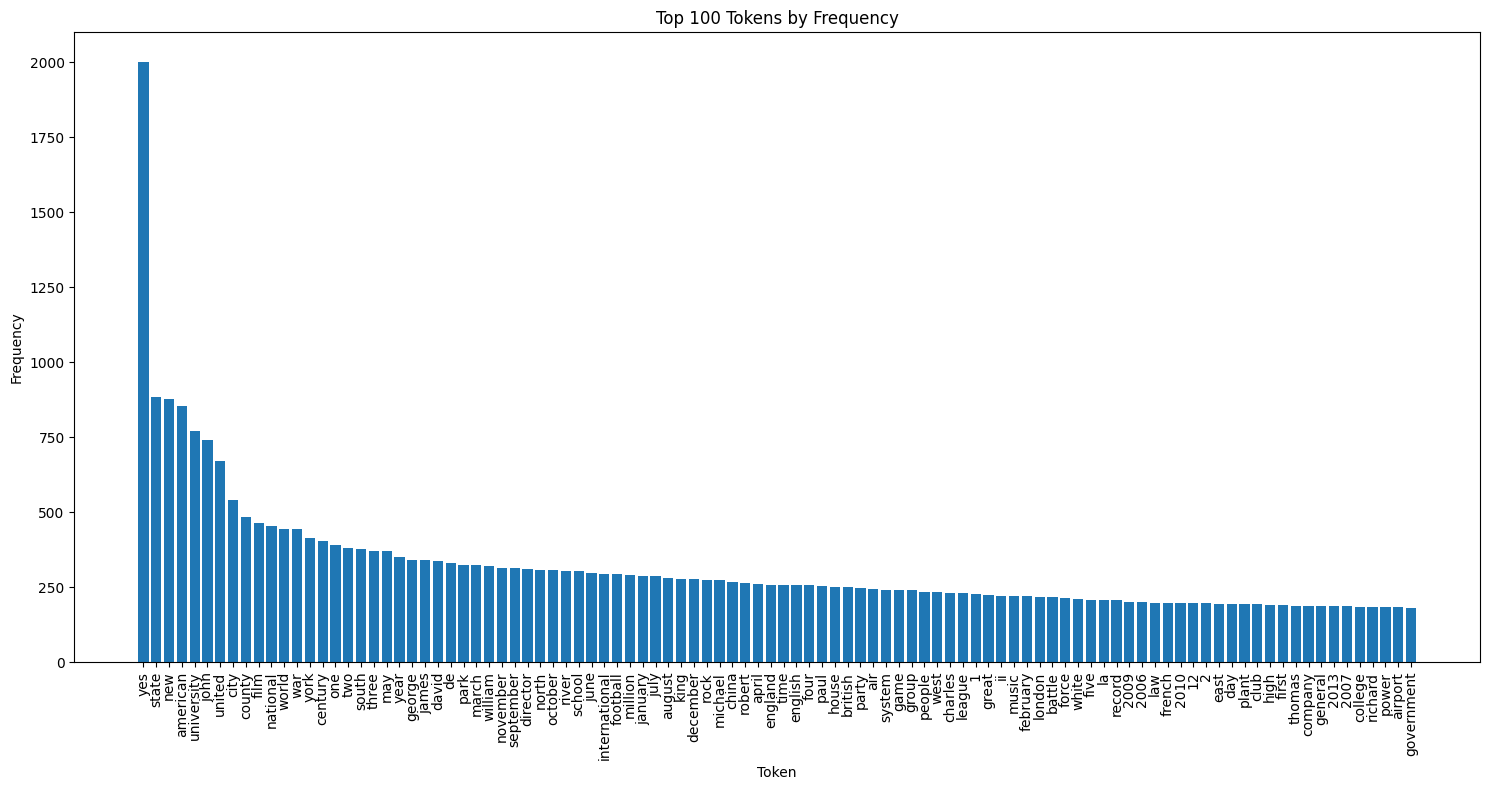

In [ ]:
# Occurrencies of each token
token_counts = Counter(flattened_tokens)

# Token extraction and corresponding facilities
tokens = list(token_counts.keys())
frequencies = list(token_counts.values())
tokens, frequencies = zip(*sorted(zip(tokens, frequencies), key=lambda x: x[1], reverse=True))  #token and facilities sorted in descending order

top_tokens_h = tokens[:100]
top_frequencies_h = frequencies[:100]

# Plot the bar plot
plt.figure(figsize=(15, 8))
plt.bar(top_tokens_h, top_frequencies_h)
plt.xlabel('Token')
plt.ylabel('Frequency')
plt.title('Top 100 Tokens by Frequency')
plt.xticks(rotation=90)  # Rotate x-axis labels for better readability
plt.tight_layout()
plt.show()

### Linear model - baseline

We first create a baseline model, to have a baseline perfmormance to better understand how well the true linear model that we're going to build perform.
This first model is, indeed, predicting only 'yes' answers, which resulted to be the most common word used in answers in the dataset.

In [ ]:
# Split the dataset
train_data, temp_data = train_test_split(df, train_size=0.9, random_state=42)
val_data, test_data = train_test_split(temp_data, test_size=5000, random_state=42)

print("Train set size:", len(train_data))
print("Validation set size:", len(val_data))
print("Test set size:", len(test_data))

print("Train set size:", len(train_data))
print("Validation set size:", len(val_data))
print("Test set size:", len(test_data))

# Prepare the data
linear_data_test = []
answers_test = []


tfidf_vectorizer = TfidfVectorizer(tokenizer = nltk.word_tokenize,
    stop_words = stopwords.words('english'),
    ngram_range = (1,2),
    max_df = 1.0,
    min_df = 10)


for datapointt in range(len(test_data)):
    string = test_data.iloc[datapointt]['question']
    for c in test_data.iloc[datapointt]['context']:
        string.join(c)
    linear_data_test.append(string)
    answers_test.append(''.join(test_data.iloc[datapointt]['answers']))


linear_data_test_series = pd.Series(linear_data_test)
answers_test_series = pd.Series(answers_test)
answers_test_tl = answers_test_series.apply(tokenize_and_lemmatize)
linear_test_data_tl = [tokenize_and_lemmatize(linear_data_test_series[i]) for i in range(len(linear_data_test_series))]

string = "yes"
predictions = []
for i in range(len(test_data)):
  predictions.append(string)

# Evaluate the model
accuracy = accuracy_score(answers_test_tl, predictions)
print("Accuracy for current batch:", accuracy)

Train set size: 120638
Validation set size: 8405
Test set size: 5000
Train set size: 120638
Validation set size: 8405
Test set size: 5000
Accuracy for current batch: 0.0166


In [ ]:
print(predictions[:100])

['yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes']


### Linear model - true model

In [ ]:
# Split the dataset
train_data, temp_data = train_test_split(df, train_size=0.9, random_state=42)
val_data, test_data = train_test_split(temp_data, test_size=5000, random_state=42)

# Print the sizes of train, val, and test sets
print("Train set size:", len(train_data))
print("Validation set size:", len(val_data))
print("Test set size:", len(test_data))

# Print the sizes of train, val, and test sets
print("Train set size:", len(train_data))
print("Validation set size:", len(val_data))
print("Test set size:", len(test_data))

# Vectorizer
tfidf_vectorizer = TfidfVectorizer(tokenizer = nltk.word_tokenize,
    ngram_range = (1,2),
    max_df = 1.0,
    min_df = 10)

# Split the dataset into smaller batches for processing
batch_size = 10000
batches = [train_data[i:i+batch_size] for i in range(0, len(train_data), batch_size)]

j = 0;
# Loop over batches
for batch in batches:
    j = j + 1
    print('epoch:', j,'\n')

    linear_data_train = []
    answers_train = []
    linear_data_test = []
    answers_test = []


    for datapoint in range(len(batch)):
        string = batch.iloc[datapoint]['question'] + batch.iloc[datapoint]['answers']
        for c in batch.iloc[datapoint]['context']:
            string.join(c)
        linear_data_train.append(string)
        answers_train.append(''.join(batch.iloc[datapoint]['answers']))

    for datapointt in range(len(test_data)):
        string = test_data.iloc[datapointt]['question']
        for c in test_data.iloc[datapointt]['context']:
            string.join(c)
        linear_data_test.append(string)
        answers_test.append(''.join(test_data.iloc[datapointt]['answers']))

    # Convert lists to pandas Series
    linear_data_train_series = pd.Series(linear_data_train)
    answers_train_series = pd.Series(answers_train)
    linear_data_test_series = pd.Series(linear_data_test)
    answers_test_series = pd.Series(answers_test)

    # Apply tokenization and lemmatization
    linear_train_data_tl = [tokenize_and_lemmatize(linear_data_train_series[i]) for i in range(len(linear_data_train_series))]
    linear_test_data_tl = [tokenize_and_lemmatize(linear_data_test_series[i]) for i in range(len(linear_data_test_series))]
    answers_train_tl = answers_train_series.apply(tokenize_and_lemmatize)
    answers_test_tl = answers_test_series.apply(tokenize_and_lemmatize)

    # Define a new logistic regression model for each batch
    logistic_model = LogisticRegression()

    # Create a new pipeline for each batch
    pipeline = Pipeline([
        ('tfidf', tfidf_vectorizer),
        ('logistic', logistic_model)
    ])

    # Fit the pipeline on the current batch
    model = pipeline.fit(linear_train_data_tl, answers_train_tl)

    # Predict on the test set
    predictions = pipeline.predict(linear_test_data_tl)


    # Evaluate the model
    accuracy = accuracy_score(answers_test_tl, predictions)
    print("Accuracy for current batch:", accuracy)

    # Clear memory by deleting variables
    del linear_data_train, answers_train, linear_data_test, answers_test
    del linear_data_train_series, answers_train_series, linear_data_test_series, answers_test_series
    del linear_train_data_tl, answers_train_tl

Train set size: 120638
Validation set size: 8405
Test set size: 5000
Train set size: 120638
Validation set size: 8405
Test set size: 5000
epoch: 1 



/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Accuracy for current batch: 0.0242
epoch: 2 



/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Accuracy for current batch: 0.0238
epoch: 3 



/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Accuracy for current batch: 0.0218
epoch: 4 



/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Accuracy for current batch: 0.0238
epoch: 5 



/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Accuracy for current batch: 0.0218
epoch: 6 



/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Accuracy for current batch: 0.0224
epoch: 7 



/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Accuracy for current batch: 0.0216
epoch: 8 



/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Accuracy for current batch: 0.0224
epoch: 9 



/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Accuracy for current batch: 0.0228
epoch: 10 



/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Accuracy for current batch: 0.023
epoch: 11 



/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Accuracy for current batch: 0.0226
epoch: 12 



/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Accuracy for current batch: 0.0222
epoch: 13 



/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Accuracy for current batch: 0.0232


In [ ]:
print(predictions[:100])

['' '' '' '' '' 'yes' '' '' 'yes' '' '' '' 'american' '' '' '' '' '' '' ''
 '' '' '' '' '' '' 'yes' '' '' '' '' '' '' '' '' '' '' '' 'american' ''
 'yes' '' '' '' '' '' '' '' '' '' '' '' 'yes' '' '' '' '' '' '' '' '' ''
 '' '' '' 'yes' '' 'yes' '' '' '' '' '' '' '' '' '' '' '' '' 'yes' '' ''
 '' '' '' '' '' '' '' '' '' '' '' '' '' 'yes' '' '' '']


## FineTuning pretrained models

### RoBERTa

#### Load Dataset

In [ ]:
datasets = DatasetDict()

datasets['train'] = Dataset.from_pandas(load_formatted_dataset(train_path))
datasets['validation'] = Dataset.from_pandas(load_formatted_dataset(validation_path))

datasets

DatasetDict({
    train: Dataset({
        features: ['id', 'src', 'answers', 'question', 'context'],
        num_rows: 134043
    })
    validation: Dataset({
        features: ['id', 'src', 'answers', 'question', 'context'],
        num_rows: 14121
    })
})

In [ ]:
datasets['train'].to_pandas()

,id,src,answers,question,context
0,8af07575b8444ae748634478f96b00d4e7dbd170,squad,"{'answer_start': [967], 'text': ['1793']}",When did Wordsworth initially attack Burke?,"In the 19th century, Burke was praised by both..."
1,7e07be1a905b70f143b2c8aff00caf16e2b32b31,squad,"{'answer_start': [360], 'text': ['Investiture ...",The clash between Henry IV and the pope was pa...,"During the early High Middle Ages, Germany was..."
2,c9dfc01655bc5abc59a1ee2583c8b3f7fba6c2e2,squad,"{'answer_start': [144], 'text': ['the Thermido...",What historical event brought about the fall o...,Some contemporaries alleged that Bonaparte was...
3,cf10ffbb5023cd0bc4637655458512b2186dc886,squad,"{'answer_start': [0], 'text': ['Morales']}",Who came up with a policy for indigenous auton...,"Morales began work on his ""indigenous autonomy..."
4,0a185aca81f9e36bfb2486f690885011a6aefb2e,hotpotqa,"{'answer_start': [42], 'text': ['Darren Lynn B...","Greg Hoffman was working on ""Saw III,"" a 2006 ...",Saw III is a 2006 horror film directed by Darr...
...,...,...,...,...,...
134038,2284448db766c9e677425cbd5df4745948cc6cb7,squad,"{'answer_start': [116], 'text': ['345']}",How many number ones have Idol singers achieve...,"Various ""American Idol"" alumni had success on ..."
134039,365152bb99ad8abdab57ca5ae2a33385094aeb91,hotpotqa,"{'answer_start': [993], 'text': ['March 11, 20...","When did the short series, in which Tom Herpic...",Thomas Herpich (born October 1979) is an Ameri...
134040,76f18c29ae79f4d51aec18bb9a2651463e6768f6,hotpotqa,"{'answer_start': [796], 'text': ['English']}",The film based on a William Shakespeare play s...,Macbeth is a 2015 British-French epic historic...
134041,019fc46c2cff8907159862b923db4adcf8751398,hotpotqa,"{'answer_start': [107], 'text': ['Michigan']}",Lovesliescrushing (stylized lovesliescrushing)...,Lovesliescrushing (stylized lovesliescrushing)...


#### Data preparation

Let's start by using the tokenizer to obtain the tokens.

In [ ]:
tokenizer = AutoTokenizer.from_pretrained(model_name)

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

In [ ]:
tokenized_datasets = datasets.map(prepare_train_features, batched=True, remove_columns=datasets["train"].column_names)

Map:   0%|          | 0/134043 [00:00<?, ? examples/s]

Map:   0%|          | 0/14121 [00:00<?, ? examples/s]

In [ ]:
validation_features = datasets["validation"].map(
    prepare_validation_features,
    batched=True,
    remove_columns=datasets["validation"].column_names,
)

Map:   0%|          | 0/14121 [00:00<?, ? examples/s]

#### Model

Let's load the model and set the training arguments which will be useful later.

In [ ]:
model = AutoModelForQuestionAnswering.from_pretrained(model_name)

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForQuestionAnswering were not initialized from the model checkpoint at FacebookAI/roberta-base and are newly initialized: ['qa_outputs.bias', 'qa_outputs.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
args = TrainingArguments(output_dir=model_path,
                         seed=RANDOM_SEED,
                         data_seed=RANDOM_SEED,
                         num_train_epochs=10,
                         weight_decay=0.2,
                         learning_rate=2e-5,
                         lr_scheduler_type=SchedulerType.REDUCE_ON_PLATEAU,
                         lr_scheduler_kwargs={
                             'mode': 'max',
                             'patience': 2,
                             'factor': 0.2,
                             'min_lr': 1e-6
                         },
                         per_device_train_batch_size=batch_size,
                         per_device_eval_batch_size=batch_size,
                         evaluation_strategy="steps",
                         logging_steps=500,
                         eval_delay=500,
                         load_best_model_at_end=True,
                         metric_for_best_model="f1",
                         greater_is_better=True,
                         save_strategy="steps",
                         save_steps=500,
                         save_total_limit=1,
                         report_to='none'      #Disable Wandb (for Kaggle)
)

In [ ]:
data_collator = default_data_collator

Now we override the trainer for visulization purpusose during the training phase

In [ ]:
class MY_Trainer(Trainer):
    def log(self, logs: Dict[str, float]) -> None:
        logs["learning_rate"] = self._get_learning_rate()
        super().log(logs)

In [ ]:
trainer = MY_Trainer(
    model,
    args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["validation"],
    data_collator=data_collator,
    tokenizer=tokenizer,
    compute_metrics=partial(compute_training_metrics, validation_features=validation_features),
    callbacks=[EarlyStoppingCallback(early_stopping_patience=4)]
)

#### Train Model

Now we're ready to train our model

In [ ]:
trainer.train()

Step,Training Loss,Validation Loss,Em,F1,Prec,Recall,Hotpotqa Em,Hotpotqa F1,Hotpotqa Prec,Hotpotqa Recall,Squad Em,Squad F1,Squad Prec,Squad Recall,Macro Em,Macro F1,Macro Prec,Macro Recall,Rate
500,1.992000,1.512770,0.561646,0.696863,0.729636,0.717116,0.490900,0.630614,0.659600,0.646179,0.613748,0.745653,0.781217,0.769359,0.552324,0.688134,0.720408,0.707769,0.000020
1000,1.262000,1.362515,0.572976,0.714926,0.735876,0.748869,0.500584,0.646586,0.669619,0.667192,0.626291,0.765256,0.784673,0.809021,0.563438,0.705921,0.727146,0.738107,0.000020
1500,1.114300,1.238897,0.599179,0.730965,0.753835,0.755443,0.519953,0.653505,0.678482,0.668208,0.657526,0.788011,0.809331,0.819689,0.588740,0.720758,0.743906,0.743949,0.000020
2000,1.050300,1.223829,0.610226,0.742331,0.771775,0.759697,0.532476,0.668590,0.698624,0.678531,0.667486,0.796640,0.825649,0.819473,0.599981,0.732615,0.762136,0.749002,0.000020
2500,1.002200,1.172960,0.615608,0.746846,0.768319,0.771046,0.546502,0.676967,0.702342,0.688220,0.666503,0.798309,0.816909,0.832045,0.606502,0.737638,0.759626,0.760133,0.000020
3000,0.990400,1.186252,0.619928,0.748891,0.778450,0.765034,0.545333,0.678472,0.705689,0.690131,0.674865,0.800753,0.832036,0.820199,0.610099,0.739613,0.768862,0.755165,0.000020
3500,0.937900,1.105796,0.626868,0.758864,0.778324,0.785520,0.554183,0.687209,0.712252,0.700141,0.680398,0.811637,0.826985,0.848399,0.617291,0.749423,0.769618,0.774270,0.000020
4000,0.914800,1.153769,0.628142,0.757483,0.782370,0.778276,0.559860,0.692492,0.719055,0.703888,0.678431,0.805347,0.829000,0.833060,0.619145,0.748919,0.774027,0.768474,0.000020
4500,0.937100,1.131328,0.634091,0.762190,0.788281,0.780029,0.560194,0.692104,0.723882,0.697581,0.688515,0.813806,0.835710,0.840750,0.624354,0.752955,0.779796,0.769166,0.000020
5000,0.901800,1.120619,0.640889,0.767827,0.797908,0.781768,0.568041,0.697816,0.729531,0.703652,0.694540,0.819388,0.848266,0.839299,0.631291,0.758602,0.788898,0.771475,0.000020


Now let's save the weights so that we can load it later on for prediction.

In [ ]:
trainer.save_model(os.path.join(model_path,"RoBertA"))

#### Evaluation

Let's load the model and use it for prediction.

In [ ]:
model_name = 'RoBertA'
load_model_path = os.path.join(model_path, model_name)

Let's now see the metrics and moreover the general performance of our model.

In [ ]:
pred = validate(datasets['validation'], load_model_path)
pd.DataFrame(pred, index=[0])

Map:   0%|          | 0/14121 [00:00<?, ? examples/s]

  0%|          | 0/14121 [00:00<?, ?it/s]

,em,f1,prec,recall,hotpotqa_em,hotpotqa_f1,hotpotqa_prec,hotpotqa_recall,squad_em,squad_f1,squad_prec,squad_recall,macro_em,macro_f1,macro_prec,macro_recall
0,0.670066,0.79422,0.817348,0.811468,0.607781,0.735233,0.762789,0.742734,0.715937,0.837663,0.857529,0.862089,0.661859,0.786448,0.810159,0.802412


### DistilBERT

#### Data preparation

In [ ]:
unrolled_data = []
for entry in data['data']:
    for context in entry['context']:
        new_entry = entry.copy()
        new_entry['context'] = context
        unrolled_data.append(new_entry)

In [ ]:
len(unrolled_data), len(data)

(236810, 134043)

In [ ]:
unrolled_data[99]

{'id': 'b31f8b9b2eb9174d30a86d03086d1445d69115d2',
 'src': 'hotpotqa',
 'answers': ['Edwin Greenwood'],
 'question': 'In between John Mulholland and Edwin Greenwood who was a British screenwriter and film director?',
 'context': ['Edwin Greenwood',
  'Edwin Greenwood (1895-1939) was a British screenwriter, novelist and film director.']}

In [ ]:
# Removing titles and taking only strings, not lists

for entry in unrolled_data:
    entry['context'] = entry['context'][1] if isinstance(entry['context'], list) else entry['context']
    entry['answers'] = entry['answers'][0] if isinstance(entry['answers'], list) else entry['answers']


In [ ]:
len(unrolled_data)

236810

Interesting insight: here "Insidious: Chapter 2" and "Insidious: Chapter 3" have been removed (copyright? censuring?)

In [ ]:
def find_answer_start(context, answer):
    match = re.search(re.escape(answer), context)
    if match:
        return match.start()
    else:
        return None

new_data = []
for entry in unrolled_data:
    answer_start = find_answer_start(entry['context'], entry['answers'])
    new_entry = {
        'answers': {
            'answer_start': [answer_start] if answer_start is not None else [],
            'text': [entry['answers']]
        },
        'context': entry['context'],
        'id': entry['id'],
        'question': entry['question']
    }
    new_data.append(new_entry)


In [ ]:
# Assuming new_data is your list of dictionaries
data_dict = {key: [entry[key] for entry in new_data] for key in new_data[0].keys()}
dataset = Dataset.from_dict(data_dict)


final_data = dataset.train_test_split(test_size=0.2)


In [ ]:
len(final_data['train']) + len(final_data['test'])

236810

Matched with the length of *unrolled_data*

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("distilbert/distilbert-base-uncased")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [ ]:
def preprocess_function(examples):
    questions = [q.strip() for q in examples["question"]]
    inputs = tokenizer(
        questions,
        examples["context"],
        max_length=384,
        truncation="only_second",
        return_offsets_mapping=True,
        padding="max_length",
    )

    offset_mapping = inputs.pop("offset_mapping")
    answers = examples["answers"]
    start_positions = []
    end_positions = []

    for i, offset in enumerate(offset_mapping):
      answer = answers[i]
      if len(answer["answer_start"])==0:
        start_positions.append(0)
        end_positions.append(0)
      else:
        start_char = answer["answer_start"][0]
        end_char = answer["answer_start"][0] + len(answer["text"][0])
        sequence_ids = inputs.sequence_ids(i)

        # Find the start and end of the context
        idx = 0
        while sequence_ids[idx] != 1:
            idx += 1
        context_start = idx
        while sequence_ids[idx] == 1:
            idx += 1
        context_end = idx - 1

        # If the answer is not fully inside the context, label it (0, 0)
        if offset[context_start][0] > end_char or offset[context_end][1] < start_char:
            start_positions.append(0)
            end_positions.append(0)
        else:
            # Otherwise it's the start and end token positions
            idx = context_start
            while idx <= context_end and offset[idx][0] <= start_char:
                idx += 1
            start_positions.append(idx - 1)

            idx = context_end
            while idx >= context_start and offset[idx][1] >= end_char:
                idx -= 1
            end_positions.append(idx + 1)

    inputs["start_positions"] = start_positions
    inputs["end_positions"] = end_positions

    return inputs

In [ ]:
tokenized_data = final_data.map(preprocess_function, batched=True, remove_columns=final_data["train"].column_names)

Map:   0%|          | 0/189448 [00:00<?, ? examples/s]

Map:   0%|          | 0/47362 [00:00<?, ? examples/s]

#### Loading and training the DistilBERT

In [ ]:
model = AutoModelForQuestionAnswering.from_pretrained("distilbert/distilbert-base-uncased")

In [ ]:
data_collator = DefaultDataCollator()

In [ ]:
training_args = TrainingArguments(
    evaluation_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=64,
    per_device_eval_batch_size=64,
    num_train_epochs=3,
    weight_decay=0.01,
    push_to_hub=False,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_data["train"],
    eval_dataset=tokenized_data["test"],
    tokenizer=tokenizer,
    data_collator=data_collator,
)

# Total span extraction loss is the sum of a Cross-Entropy for the start and end positions.
trainer.train()

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss
1,1.047400,0.923293
2,0.830800,0.855426
3,0.709500,0.847619


TrainOutput(global_step=8883, training_loss=0.9232585872197948, metrics={'train_runtime': 11039.5669, 'train_samples_per_second': 51.482, 'train_steps_per_second': 0.805, 'total_flos': 5.569192911344026e+16, 'train_loss': 0.9232585872197948, 'epoch': 3.0})

In [ ]:
trainer.save_model("model/DistilBERT")

#### Prediction

In [ ]:
# Path to your pre-trained model directory
model_path = "model/DistilBERT"

# Load the model
model = AutoModelForQuestionAnswering.from_pretrained(model_path)

In [ ]:
question = "Who developed the theory of relativity?"
context = "Albert Einstein was a theoretical physicist who developed the theory of relativity, one of the two pillars of modern physics. His work is also known for its influence on the philosophy of science. He is best known to the general public for his mass–energy equivalence formula E=mc², which has been dubbed \"the world's most famous equation\"."

In [ ]:
# Load the model using the pipeline function
question_answerer = pipeline("question-answering", model=model_path)
question_answerer(question=question, context=context)

{'score': 0.9933983683586121,
 'start': 0,
 'end': 15,
 'answer': 'Albert Einstein'}

In [ ]:
pred = validate(datasets['validation'], model_path)
pred

{'em': 0.4697259400892288, 'f1': 0.5829247532256987, 'prec': 0.6038824364031496, 'recall': 0.6041873880802852, 'hotpotqa_em': 0.2751711471030222, 'hotpotqa_f1': 0.36745327452176024, 'hotpotqa_prec': 0.3857789360043496, 'hotpotqa_recall': 0.3760926977699393, 'squad_em': 0.6130103295622233, 'squad_f1': 0.7416137210021165, 'squad_prec': 0.7645098175994626, 'squad_recall': 0.7721730128058952, 'macro_em': 0.4440907383326228, 'macro_f1': 0.5545334977619384, 'macro_prec': 0.5751443768019061, 'macro_recall': 0.5741328552879172}


### T5

#### Data preparation and loading the model

In [ ]:
tokenizer = T5TokenizerFast.from_pretrained("t5-base")
model = T5ForConditionalGeneration.from_pretrained("t5-base", return_dict=True)
question_len = 256   # Question Length
context_len = 32    # Target Length
batch_size = 16

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.39M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/1.21k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/892M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

In [ ]:
# Extracting context, question, and answers from the dataset

def prepare_data(data):
    articles = []

    for sample in data["data"]:
        for i in range(len(sample["context"])):
            inputs = {"context": sample["context"][i][0], "question": sample["question"], "answer": sample["answers"][0]}
            articles.append(inputs)
    return articles

In [ ]:
full_data = prepare_data(data) + prepare_data(dev)

In [ ]:
data_df = pd.DataFrame(full_data)

In [ ]:
data_df["context"]

0                               Edmund Burke
1                                Middle Ages
2                                   Napoleon
3         Indigenous peoples of the Americas
4                                    Saw III
                         ...                
259181                   On the Buses (film)
259182                            Pat Ashton
259183                          Japanese yen
259184       Asahi-Ryokuken Yomiuri Memorial
259185                             New Delhi
Name: context, Length: 259186, dtype: object

In [ ]:
class QA_Dataset(Dataset):
    def __init__(self, tokenizer, dataframe, question_len, context_len):
        self.tokenizer = tokenizer
        self.question_len = question_len
        self.context_len = context_len
        self.data = dataframe
        self.questions = self.data["question"]
        self.context = self.data["context"]
        self.answer = self.data["answer"]

    def __len__(self):
        return len(self.questions)

    def __getitem__(self, idx):
        question = self.questions[idx]
        context = self.context[idx]
        answer = self.answer[idx]

        question_tokenized = self.tokenizer(question, context, max_length=self.question_len, padding="max_length",
                                                    truncation=True, pad_to_max_length=True, add_special_tokens=True)
        answer_tokenized = self.tokenizer(answer, max_length=self.context_len, padding="max_length",
                                          truncation=True, pad_to_max_length=True, add_special_tokens=True)

        labels = torch.tensor(answer_tokenized["input_ids"], dtype=torch.long)
        labels[labels == 0] = -100

        return {
            "input_ids": torch.tensor(question_tokenized["input_ids"], dtype=torch.long),
            "attention_mask": torch.tensor(question_tokenized["attention_mask"], dtype=torch.long),
            "labels": labels,
            "decoder_attention_mask": torch.tensor(answer_tokenized["attention_mask"], dtype=torch.long)
        }

In [ ]:
# Dataloader

train_data, val_data = train_test_split(data_df, test_size=0.2, random_state=42)

train_sampler = RandomSampler(train_data.index)
val_sampler = RandomSampler(val_data.index)

qa_dataset = QA_Dataset(tokenizer, data_df, question_len, context_len)

train_loader = DataLoader(qa_dataset, batch_size=batch_size, sampler=train_sampler)
val_loader = DataLoader(qa_dataset, batch_size=batch_size, sampler=val_sampler)

#### Training T5

In [ ]:
# Check if a GPU is available and set the device accordingly
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model.to(device)
optimizer = AdamW(model.parameters(), lr=3e-4)


train_loss = 0
val_loss = 0
train_batch_count = 0
val_batch_count = 0

for epoch in range(3):
    model.train()
    for batch in tqdm(train_loader, desc="Training batches"):
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)
        decoder_attention_mask = batch["decoder_attention_mask"].to(device)

        outputs = model(
                          input_ids=input_ids,
                          attention_mask=attention_mask,
                          labels=labels,
                          decoder_attention_mask=decoder_attention_mask
                        )

        optimizer.zero_grad()
        outputs.loss.backward()
        optimizer.step()
        train_loss += outputs.loss.item()
        train_batch_count += 1

    # Evaluation
    model.eval()
    with torch.no_grad():  # Disable gradient calculation for validation
        for batch in tqdm(val_loader, desc="Validation batches"):
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["labels"].to(device)
            decoder_attention_mask = batch["decoder_attention_mask"].to(device)

            outputs = model(
                              input_ids=input_ids,
                              attention_mask=attention_mask,
                              labels=labels,
                              decoder_attention_mask=decoder_attention_mask
                            )

            val_loss += outputs.loss.item()
            val_batch_count += 1

    print(f"{epoch+1}/{3} -> Train loss: {train_loss / train_batch_count}\tValidation loss: {val_loss / val_batch_count}")


Validation batches: 100%|██████████| 3240/3240 [08:38<00:00,  6.25it/s]


1/3 -> Train loss: 2.512890203922619	Validation loss: 1.8822217111050348


Validation batches: 100%|██████████| 3240/3240 [08:38<00:00,  6.25it/s]


2/3 -> Train loss: 2.293811530107057	Validation loss: 1.6915944027863903


Validation batches: 100%|██████████| 3240/3240 [08:38<00:00,  6.25it/s]

3/3 -> Train loss: 2.1168517547142174	Validation loss: 1.5216530005781004


In [ ]:
model.save_pretrained("model/T5")
tokenizer.save_pretrained("model/T5_tokenizer")

('results_finetuning/T5_tokenizer/tokenizer_config.json',
 'results_finetuning/T5_tokenizer/special_tokens_map.json',
 'results_finetuning/T5_tokenizer/spiece.model',
 'results_finetuning/T5_tokenizer/added_tokens.json',
 'results_finetuning/T5_tokenizer/tokenizer.json')

#### Prediction

In [ ]:
def predict_answer(model, tokenizer, context, question):
    inputs = tokenizer(question, context, max_length=question_length, padding="max_length", truncation=True, add_special_tokens=True)

    input_ids = torch.tensor(inputs["input_ids"], dtype=torch.long).to(device).unsqueeze(0)
    attention_mask = torch.tensor(inputs["attention_mask"], dtype=torch.long).to(device).unsqueeze(0)

    outputs = model.generate(input_ids=input_ids, attention_mask=attention_mask)

    predicted_answer = tokenizer.decode(outputs.flatten(), skip_special_tokens=True)

    return predicted_answer

In [ ]:
path_model = "model/T5"
tokenizer = T5TokenizerFast.from_pretrained("model/T5_tokenizer")
model = T5ForConditionalGeneration.from_pretrained("model/T5")


# Move the model to the device
model.to(device)

T5ForConditionalGeneration(
  (shared): Embedding(32128, 768)
  (encoder): T5Stack(
    (embed_tokens): Embedding(32128, 768)
    (block): ModuleList(
      (0): T5Block(
        (layer): ModuleList(
          (0): T5LayerSelfAttention(
            (SelfAttention): T5Attention(
              (q): Linear(in_features=768, out_features=768, bias=False)
              (k): Linear(in_features=768, out_features=768, bias=False)
              (v): Linear(in_features=768, out_features=768, bias=False)
              (o): Linear(in_features=768, out_features=768, bias=False)
              (relative_attention_bias): Embedding(32, 12)
            )
            (layer_norm): T5LayerNorm()
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (1): T5LayerFF(
            (DenseReluDense): T5DenseActDense(
              (wi): Linear(in_features=768, out_features=3072, bias=False)
              (wo): Linear(in_features=3072, out_features=768, bias=False)
              (dropout): Dro

In [ ]:
question = "Who developed the theory of relativity?"
context = "Albert Einstein was a theoretical physicist who developed the theory of relativity, one of the two pillars of modern physics. His work is also known for its influence on the philosophy of science. He is best known to the general public for his mass–energy equivalence formula E=mc², which has been dubbed \"the world's most famous equation\"."

In [ ]:
predict_answer(model, tokenizer, context, question)

'Albert Einstein'

# Part 3

For part 3 we decided to add some features to our pretrained model. In particular we decided to add a speech-to-text to directly question the model, plus, we needed a way fo retrieve the contexts for the incoming questions. To do so, we search for the contexts on wikipedia using the wikipedia library. We then collect them and give them as input to our model which will provide an answer which highly rely on the context quality.

#### Load the model and set the dataset


In [ ]:
model_name = 'RoBertA'
load_model_path = os.path.join(model_path, model_name)

In [ ]:
load_dataset = True
dataset_name = 'context_dataset'
dataset_path = os.path.join(data_path, dataset_name)

# Set the funtion for the context retrieve
find_context_function = get_context

In [ ]:
if not load_dataset:
    N=10
    datasets = Dataset.from_pandas(load_formatted_dataset_context(validation_path, find_context_function, N))
    datasets.save_to_disk(dataset_path)
    print('Datset saved to memory')

datasets = load_from_disk(dataset_path)
print(datasets)

Dataset({
    features: ['id', 'src', 'answers', 'question', 'context'],
    num_rows: 1000
})


#### Prediction

In [ ]:
pred = validate(datasets, load_model_path)
pd.DataFrame(pred, index=[0])

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

,em,f1,prec,recall,hotpotqa_em,hotpotqa_f1,hotpotqa_prec,hotpotqa_recall,squad_em,squad_f1,squad_prec,squad_recall,macro_em,macro_f1,macro_prec,macro_recall
0,0.136,0.188252,0.19117,0.195658,0.006679,0.008881,0.009121,0.008904,0.011805,0.016609,0.016791,0.017503,0.009242,0.012745,0.012956,0.013203


## Speech-to-text

First, we start by getting the path of a the audio that we want to transcribe.

In [ ]:
audio_file = os.path.join(audio_path, 'question1.wav')

After that, we load the model from whisper that will take care of the transcription.

In [ ]:
whisper_model = whisper.load_model("base")

##### Code

In [ ]:
camera = CameraStream(constraints={'audio': True,'video':False})
recorder = AudioRecorder(stream=camera)
recorder

AudioRecorder(audio=Audio(value=b'', format='webm'), stream=CameraStream(constraints={'audio': True, 'video': …

In [ ]:
recorder.save(audio_file)

In [ ]:
audio, sr = librosa.load(audio_file, sr=16000)

<ipython-input-148-a673f846eda4>:1: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sr = librosa.load(audio_file, sr=16000)
/usr/local/lib/python3.10/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


Let's print the audio graph and the corresponding frequencies.

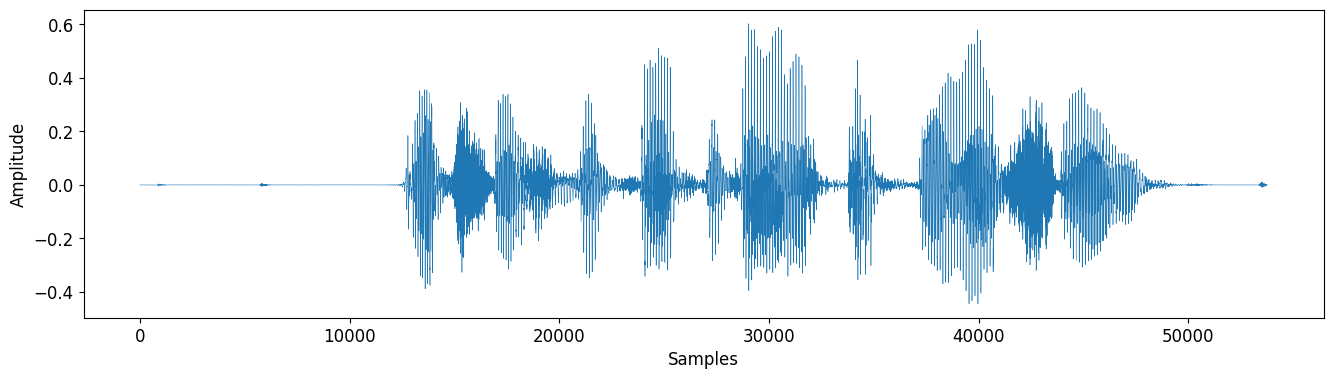

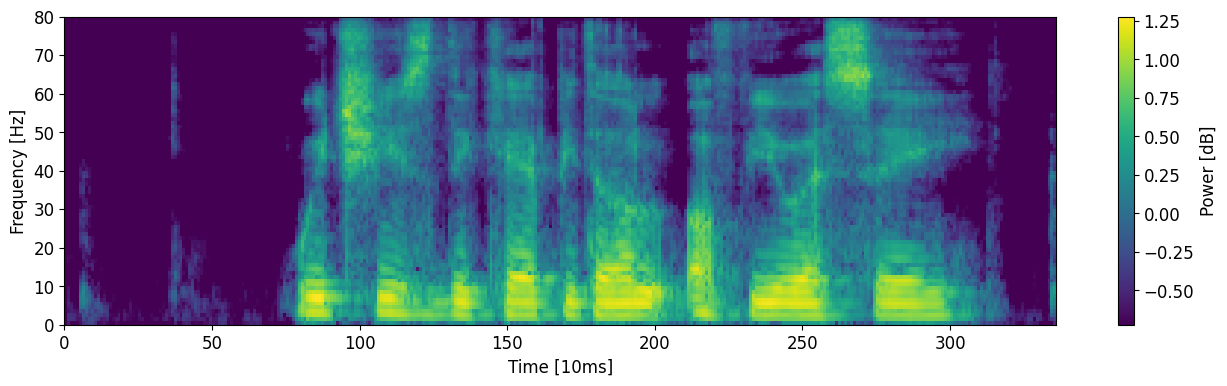

In [ ]:
printFrequency(audio)

Let's see what does it have understood.

In [ ]:
question = whisper_model.transcribe(audio_file)['text']
question

' which is the capital of USA.'

In [ ]:
context = get_context(question)

Page  USA Capital  not found.
Page  Washington, D.C.  not found.


In [ ]:
print(single_prediction(question, context))

Question:  Which is the capital of USA?
Answer:  Washington
